# Recommender Systems Assignment 1 - Collaborative Filtering

## Lakkas Ioannis 

### Import libraries

In [153]:
# Basic libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import re

# SVD library
from scipy.sparse.linalg import svds

# MSE
from sklearn.metrics import mean_squared_error

#sklearn
from sklearn.metrics.pairwise import pairwise_distances

#surprise
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise.model_selection import cross_validate

#MinHash
from datasketch import MinHash, MinHashLSH


## Amazon Software products

#### Dataset

* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* vote - helpful votes of the review
* style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)
* image - images that users post after they have received the product

In [2]:
df = pd.read_json(r'dataset/Software.json', lines=True)

In [3]:
df.head(10)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN
3,3,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN
4,5,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN
5,4,True,"08 15, 2011",AGN3T5ERYJN5A,0132147556,{'Format:': ' Paperback'},Skipper management,"Strong backgroung, good read, quite up to date...",E-marketing 6th ed,1313366400,NaN,NaN
6,3,False,"10 9, 2010",AHPK2GD0SQC59,0132147556,{'Format:': ' Paperback'},dstmars,If you live on Mars and never heard of the int...,Mars calling Earth....what is internet?,1286582400,NaN,NaN
7,5,False,"10 3, 2010",A35UC8LHA6TILH,0132147556,{'Format:': ' Paperback'},Knw1989,i got this book on amazon and it ended up savi...,"good book, saved me a lot of money",1286064000,NaN,NaN
8,5,True,"10 3, 2010",A2IH0AJPR7IWG3,0132147556,{'Format:': ' Paperback'},Tam,I was very happy with this purchase because th...,Super fast,1286064000,NaN,NaN
9,5,True,"05 23, 2010",AL87GELNJGOH3,0132147556,{'Format:': ' Paperback'},R. Rowley,Recieved in a timely manner- book in great con...,E-Marketing,1274572800,NaN,NaN


### Metadata dataset

* asin - ID of the product, e.g. 0000031852
* title - name of the product
* feature - bullet-point format features of the product
* description - description of the product
* price - price in US dollars (at time of crawl)
* imageURL - url of the product image
* imageURL - url of the high resolution product image
* related - related products (also bought, also viewed, bought together, buy after viewing)
* salesRank - sales rank information
* brand - brand name
* categories - list of categories the product belongs to
* tech1 - the first technical detail table of the product
* tech2 - the second technical detail table of the product
* similar - similar product table

In [4]:
df_meta = pd.read_json(r'dataset/meta_Software.json', lines=True)

In [5]:
df_meta.head(10)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],,HOLT. RINEHART AND WINSTON,[],"25,550 in Software (",[],Software,,</div>,.a-box-inner{background-color:#fff}#alohaBuyBo...,0030672120,[],[],NaN
1,[],,"[, <b>Latin rhythms that will get your kids si...",,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",[],,McGraw Hill,[],"15,792 in Software (",[],Software,,</div>,,0071480935,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,[],,[<b>Connect is the only integrated learning sy...,,Connect with LearnSmart Access Card for Microb...,[],,McGraw-Hill Science/Engineering/Math,[],"16,900 in Software (",[],Software,,</div>,,007329506X,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
3,[],,[],,LearnSmart Standalone Access Card for Prescott...,[],,McGraw-Hill Education,[],"12,986 in Software (",[],Software,,</div>,,0073513458,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,[],,[<i>Anatomy &amp; Physiology Revealed Cat</i> ...,,Anatomy &amp; Physiology Revealed Student Acce...,"[0323394612, 0323227937, 1118527488]",,McGraw-Hill Education,[],"14,861 in Software (",[],Software,,</div>,$4.83,0073525758,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
5,[],,"[John Coburn grew up in the Hawaiian Islands, ...",,Connect Math by ALEKS Access Card 52 Weeks for...,[],,McGraw-Hill Science/Engineering/Math,[],"43,708 in Software (",[],Software,,</div>,,0077340701,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
6,[],,[<b>Connect is the only integrated learning sy...,,Connect Access Card for Microbiology Fundament...,[],,Brand: McGraw-Hill Science/Engineering/Math,[Used Book in Good Condition],"8,512 in Software (","[0078021049, 1259293173, 0073402354, 126009216...",Software,,</div>,,0077369823,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
7,[],,[<i>Living with Arts </i> approach to art appr...,,Connect Art with McGraw-Hill LearnSmart Access...,[],,McGraw-Hill Humanities/Social Sciences/Languages,[],"11,081 in Software (",[],Software,,</div>,,0077410297,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
8,[],,[McGraw-Hill Connect is a digital teaching and...,,Connect Biology Access Card for Essentials of ...,[],,McGraw-Hill Science/Engineering/Math,[],"17,395 in Software (",[],Software,,</div>,$47.23,007739688X,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
9,[],,[<i>Living with Arts </i> approach to art appr...,,Connect Art PLUS with McGraw-Hill LearnSmart A...,[],,McGraw-Hill Education,[],"6,432 in Software (",[1259360423],Software,,</div>,,0077410319,[],[],NaN


#### Exploratory Data Analysis

In [6]:
print("Total data ")
print("-" * 50)
print("\nTotal no of ratings :", df.shape[0])
print("Total No of users   :", len(np.unique(df.reviewerID)))
print("Total No of products  :", len(np.unique(df.asin)))

Total data 
--------------------------------------------------

Total no of ratings : 459436
Total No of users   : 375147
Total No of products  : 21663


In [7]:
def df_dist(df, colname, norm=False):
    new_df = df[colname].value_counts(normalize=norm).reset_index()
    new_df.columns = [colname, 'count']
    return new_df

In [8]:
dist_user = df_dist(df, 'reviewerID')
dist_prod = df_dist(df, 'asin')

In [9]:
print('Average number of ratings per product: %.2f\nAverage number of ratings per user: %.2f' % (dist_user['count'].mean(),
                                                                                              dist_prod['count'].mean()))

Average number of ratings per product: 1.22
Average number of ratings per user: 21.21


#### Plot rating distribution

In [10]:
def plot_rating_distribution(df):
    palette = sns.color_palette("RdBu", 10)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x='overall', data=df, palette=palette)
    ax.set_title('Distribution of product ratings')

    plt.show()

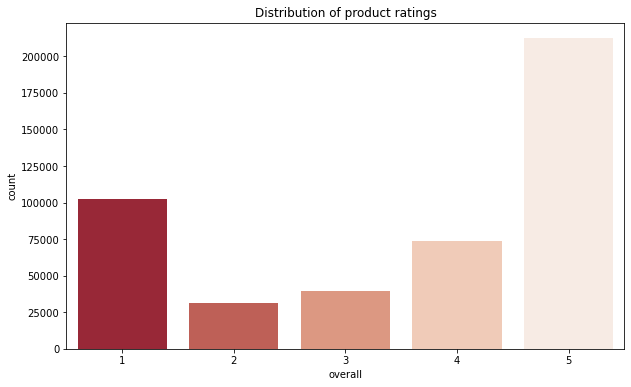

In [228]:
plot_rating_distribution(df)

* We can observe that the more ratings is 5 and the second more frequent rating value is the 0.

#### Plot rating over time

In [12]:
df['year'] = df['reviewTime'].str.split(', ').str[1].astype(int)
df['month'] = df['reviewTime'].str[:2].astype(int)

In [13]:
def products_groupby(df, column):
    df_groupby = df.groupby(column).agg({'verified': 'count', 'overall': 'mean'}).reset_index()
    df_groupby.columns = [column, 'count', 'avg_rating']
    return df_groupby

In [14]:
df_grouped = products_groupby(df, 'year')

In [15]:
def plot_rating_over_time(df, column):
    palette = sns.color_palette("RdBu", len(df[column].unique()))
    gridsize = (3, 1)
    fig = plt.figure(figsize=(12, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=1, rowspan=2)
    
    sns.lineplot(x=column, y='avg_rating', data=df, palette=palette, ax=ax1)
    ax1.set_title(f'Average rating by {column} of rating')
    ax1.set_ylim([0,10])
    
    sns.barplot(x=column, y='count', data=df, palette=palette, ax=ax2)
    ax2.set_title(f'Number of product ratings by {column} of rating')
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

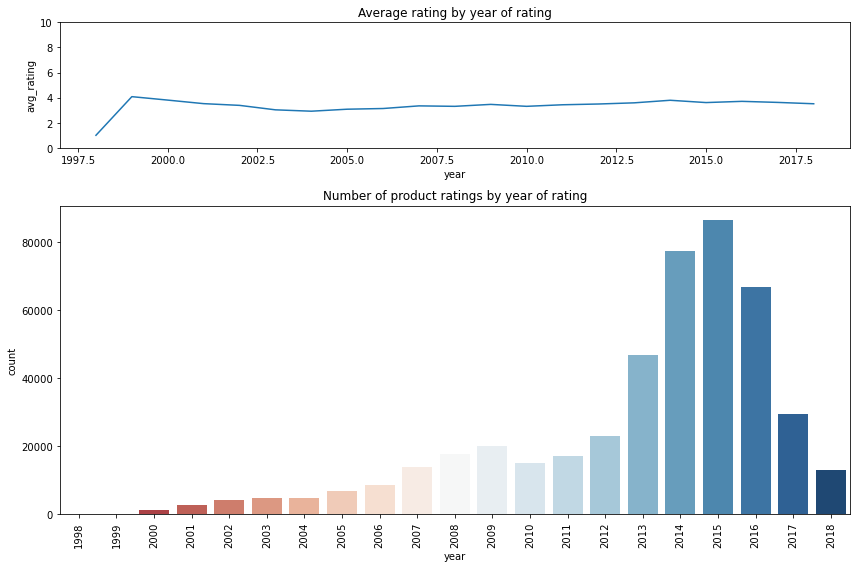

In [16]:
plot_rating_over_time(df_grouped, 'year')

* We can observe that the more ratings have been at 2015. 

In [17]:
df_grouped = products_groupby(df, 'month')

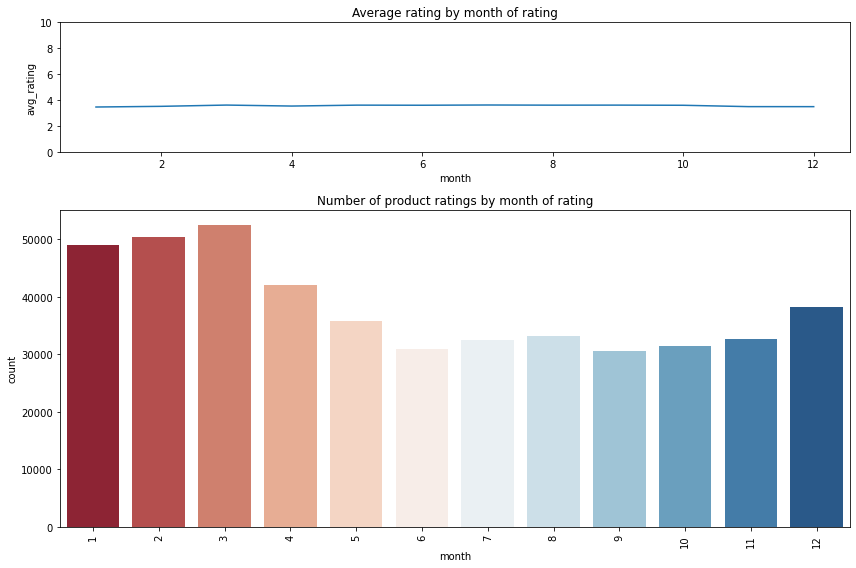

In [18]:
plot_rating_over_time(df_grouped, 'month')

#### Top products and users

In [19]:
def draw_top_chart(data, x, y_list, title):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    plt.xticks(rotation=90)

    palette = sns.color_palette("RdBu", len(data))

    sns.barplot(x=x, y=y_list[0], data=data, palette=palette, ax=ax1)
    ax1.set_title(title)
    
    ax2 = ax1.twinx()
    sns.scatterplot(x=x, y=y_list[1], data=data, color='black', ax=ax2)

    plt.show()

In [20]:
df_products = products_groupby(df, 'asin')

In [21]:
df_products = df_products.merge(df_meta, on='asin')

* Find most popular products

In [22]:
titles_top_popular = df_products.sort_values('count', ascending=False).head(20)

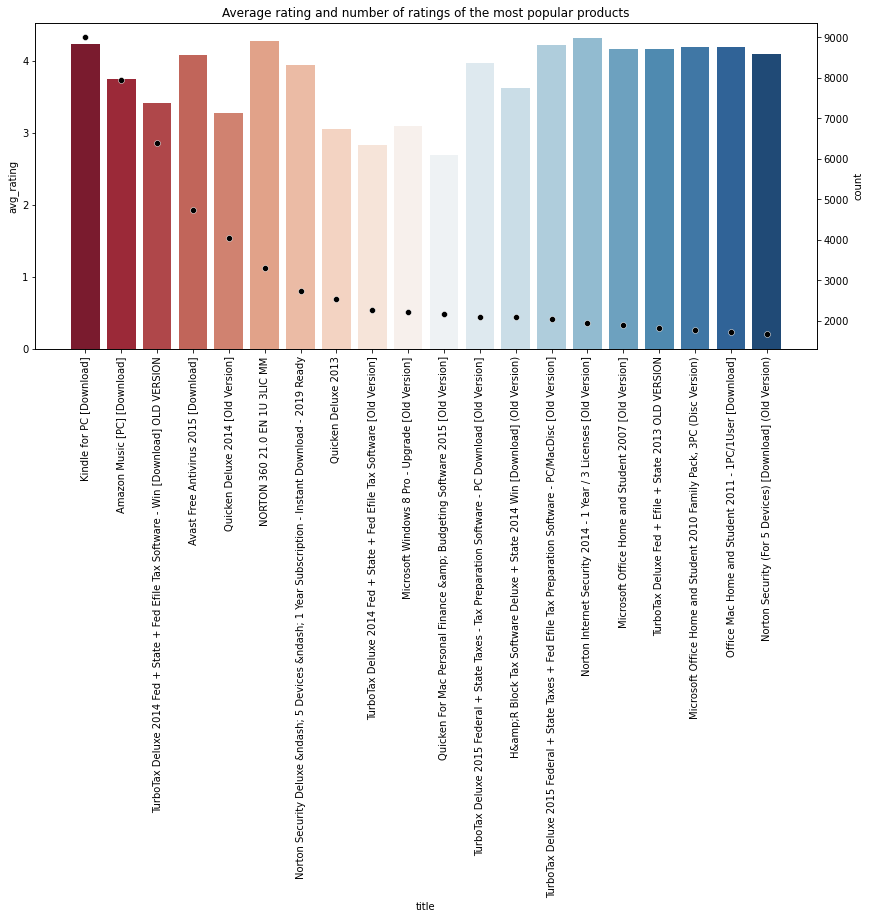

In [23]:
draw_top_chart(titles_top_popular, 'title', ['avg_rating', 'count'], 
               'Average rating and number of ratings of the most popular products')

##### Top users

In [24]:
df_users = products_groupby(df, 'reviewerName')

* Find most popular products

In [25]:
users_top_popular = df_users.sort_values('count', ascending=False).head(20)

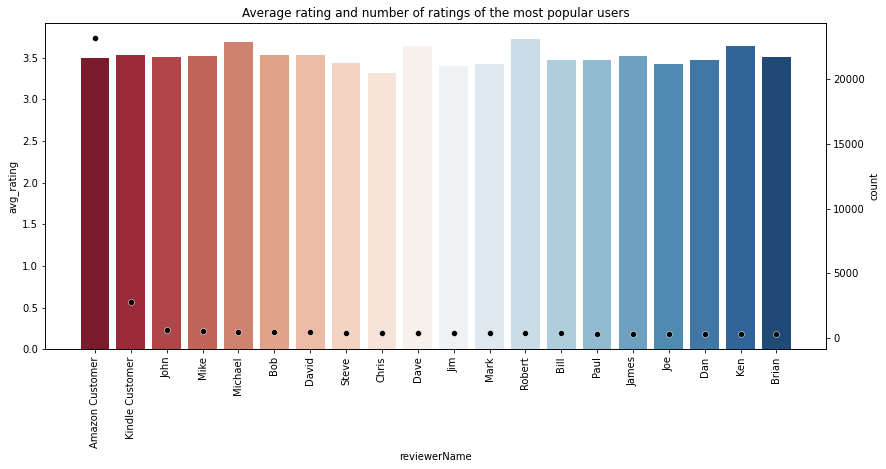

In [26]:
draw_top_chart(users_top_popular, 'reviewerName', ['avg_rating', 'count'], 
               'Average rating and number of ratings of the most popular users')

### Data Cleaning

* Cleaning the dataset 

In [27]:
df_cleaned = df[['reviewerID', 'asin', 'overall']]

In [28]:
df_cleaned

,reviewerID,asin,overall
0,A240ORQ2LF9LUI,0077613252,4
1,A1YCCU0YRLS0FE,0077613252,4
2,A1BJHRQDYVAY2J,0077613252,1
3,APRDVZ6QBIQXT,0077613252,3
4,A2JZTTBSLS1QXV,0077775473,5
...,...,...,...
459431,AGEWYJ2NF5C2H,B01HF41TKI,2
459432,A3VCFV8WEQG9R5,B01HF3G4BS,1
459433,A3DXGHJF6SOHNC,B01HF3G4BS,5
459434,A1WOS4D7QA06DO,B01HJAMWOK,5


In [29]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459436 entries, 0 to 459435
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewerID  459436 non-null  object
 1   asin        459436 non-null  object
 2   overall     459436 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.5+ MB


In [30]:
df_cleaned[['reviewerID', 'asin', 'overall']]

,reviewerID,asin,overall
0,A240ORQ2LF9LUI,0077613252,4
1,A1YCCU0YRLS0FE,0077613252,4
2,A1BJHRQDYVAY2J,0077613252,1
3,APRDVZ6QBIQXT,0077613252,3
4,A2JZTTBSLS1QXV,0077775473,5
...,...,...,...
459431,AGEWYJ2NF5C2H,B01HF41TKI,2
459432,A3VCFV8WEQG9R5,B01HF3G4BS,1
459433,A3DXGHJF6SOHNC,B01HF3G4BS,5
459434,A1WOS4D7QA06DO,B01HJAMWOK,5


#### Analysis of users/ products

In [31]:
no_of_rated_products_per_user = df_cleaned.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

reviewerID
A5JLAU2ARJ0BO     73
A680RUE1FDO8B     71
A225G2TFM76GYX    69
A3W4D8XOGLWUN5    68
A15S4XW3CRISZ5    66
Name: overall, dtype: int64

* Keep only products with at least 5 ratings

In [32]:
df_prods = df_cleaned.groupby(by='asin')['overall'].count().sort_values(ascending=False).reset_index()

In [33]:
rat = df_prods[df_prods['overall'] >= 1].asin

In [34]:
ratings_df =  df_cleaned[df_cleaned['asin'].isin(rat)]

* Keep only users with at least 8 ratings

In [35]:
df_prods = df_cleaned.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False).reset_index()

In [36]:
rat = df_prods[df_prods['overall'] >= 3].reviewerID

In [37]:
ratings_df =  ratings_df[ratings_df['reviewerID'].isin(rat)]

In [38]:
ratings_df

,reviewerID,asin,overall
21,A38NELQT98S4H8,0321719816,4
22,A3QJU4FEN8PQSZ,0321719816,4
23,ACJT8MUC0LRF0,0321719816,5
24,A2RQ0AT4XZUIXL,0321719816,5
25,AYUF7YETYOLNX,0321719816,5
...,...,...,...
459403,AVU1ILDDYW301,B01HAP3NUG,3
459406,A2LW5AL0KQ9P1M,B01HAP3NUG,4
459411,AZ515FFZ7I2P7,B01HAP47PQ,3
459415,A2WPL6Y08K6ZQH,B01HAP47PQ,4


### Train test split

* We create a train-test split with stratify in order to keep the same portion of users in both sets.

In [40]:
from sklearn.model_selection import train_test_split
y = ratings_df.pop('reviewerID')
X_train, X_test, y_train, y_test = train_test_split( ratings_df, y, test_size=0.3, random_state=42, stratify=y)

In [41]:
ratings_df = pd.concat([ratings_df, y], axis=1)

In [42]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

* We validate the rating distribution in train set.

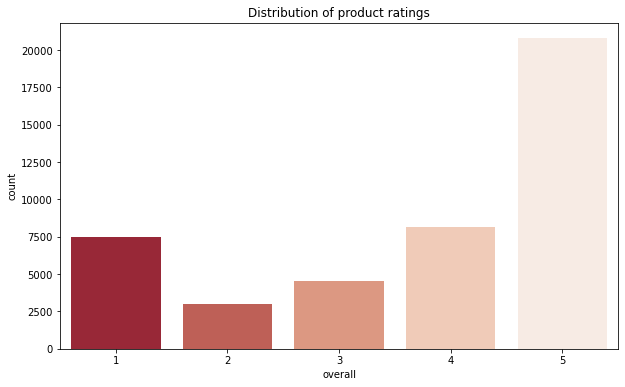

In [43]:
plot_rating_distribution(train_data)

* We validate the rating distribution in test set.

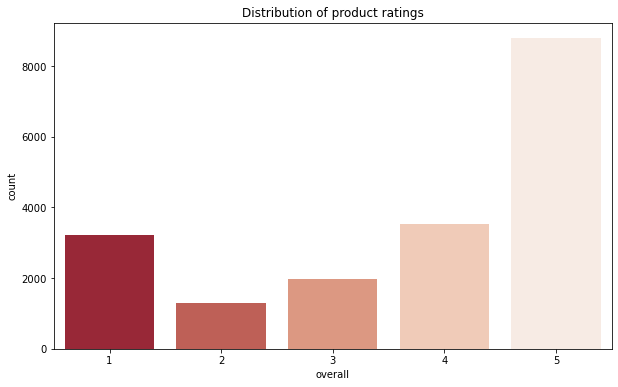

In [44]:
plot_rating_distribution(test_data)

* Also we check the users with the most ratings in both setings and as we can observe some users are presented in both sets in top positions. These users actually are the users with the more ratings of all the dataset

In [45]:
no_rated_product_per_user = train_data.groupby(by = "reviewerID")["overall"].count().sort_values(ascending = False)
no_rated_product_per_user.head(30)

reviewerID
A5JLAU2ARJ0BO     51
A680RUE1FDO8B     50
A225G2TFM76GYX    48
A3W4D8XOGLWUN5    48
A15S4XW3CRISZ5    46
A20DZX38KRBIT8    45
A3VL4RXCWNSR3H    37
A31N0XY2UTB25C    34
A1IU7S4HCK1XK0    29
ANGGNFE8DXGYC     27
A3TUZOJZM9008Y    27
A1F1A0QQP2XVH5    26
A32QOZWIKQDNZX    26
A2GH7T0J1FRX06    25
A2OPWMG3XM3W1T    25
A2IE7YPWUYZAXS    23
A250AXLRBVYKB4    22
AD0J5KK4WQXNS     22
A11KZ906QD08C5    22
AQCJWSMSURQI2     22
A2DV14M0BC6YY1    22
ATDE9JYCPI0L1     21
A1MRPX3RM48T2I    20
A12DQZKRKTNF5E    20
A376OJHLE6SU9Q    20
AGTO21BHY08LF     20
A1C9C1QOQB94RT    20
A2AV7Q95QGPTO0    20
A3OXHLG6DIBRW8    20
A105S56ODHGJEK    20
Name: overall, dtype: int64

In [46]:
no_rated_product_per_user = test_data.groupby(by = "reviewerID")["overall"].count().sort_values(ascending = False)
no_rated_product_per_user.head(15)

reviewerID
A5JLAU2ARJ0BO     22
A680RUE1FDO8B     21
A225G2TFM76GYX    21
A15S4XW3CRISZ5    20
A3W4D8XOGLWUN5    20
A20DZX38KRBIT8    19
A3VL4RXCWNSR3H    16
A31N0XY2UTB25C    15
A1IU7S4HCK1XK0    13
ANGGNFE8DXGYC     12
A2OPWMG3XM3W1T    11
A1F1A0QQP2XVH5    11
A32QOZWIKQDNZX    11
A2GH7T0J1FRX06    11
A3TUZOJZM9008Y    11
Name: overall, dtype: int64

In [47]:
len(y_train.unique())

14739

In [48]:
len(y_test.unique())

14739

### Matrix Factorization using SVD

* Unique user and products number

In [49]:
user_num = ratings_df.reviewerID.unique().shape[0]
product_num = ratings_df.asin.unique().shape[0]

user_num, product_num

(14739, 9458)

* We compute the dataset similarity

In [50]:
sparsity = round(1.0 - len(ratings_df) / float(user_num * product_num), 3)
print (sparsity)

1.0


* Find min and max ratings of the dataset

In [51]:
max_rat = max(ratings_df.overall)
min_rat = min(ratings_df.overall)

* Convert the ratings frame to a user X products matrix

In [52]:
ratings_matrix = train_data.pivot_table(index = 'reviewerID', columns ='asin', values = 'overall', aggfunc='mean').fillna(ratings_df.overall.mean())
ratings_matrix

asin,0077613252,0131433172,0133928071,0201656302,031024837X,0310258928,0321700945,0321719816,0321719824,0321786858,...,B01GGUTDTG,B01GN985R6,B01GQA3NUG,B01H33IRL0,B01H39M7ME,B01HAP3NJM,B01HAP3NUG,B01HAP3TX2,B01HAP47PQ,B01HF3G4BS
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0206237Y9WNDF0GWVPZ,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
A0735469C3RVU9AWMDCE,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
A1000SU5PFV1EQ,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
A1005HKYSSJ9L1,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
A100UD67AHFODS,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZY6XD8GHT1F7,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
AZYJ04EZX3ZUA,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481
AZYJE40XW6MFG,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,...,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481,3.718481


* Convert the matrix into an array

In [53]:
ratings_np = ratings_matrix.values
ratings_np

array([[3.7184811, 3.7184811, 3.7184811, ..., 3.7184811, 3.7184811,
        3.7184811],
       [3.7184811, 3.7184811, 3.7184811, ..., 3.7184811, 3.7184811,
        3.7184811],
       [3.7184811, 3.7184811, 3.7184811, ..., 3.7184811, 3.7184811,
        3.7184811],
       ...,
       [3.7184811, 3.7184811, 3.7184811, ..., 3.7184811, 3.7184811,
        3.7184811],
       [3.7184811, 3.7184811, 3.7184811, ..., 3.7184811, 3.7184811,
        3.7184811],
       [3.7184811, 3.7184811, 3.7184811, ..., 3.7184811, 3.7184811,
        3.7184811]])

* Compute the average rating per user

In [54]:
user_means= np.mean(ratings_np, axis = 1)
user_means.shape

(14739,)

In [55]:
user_means[0]

3.7183001693759583

* Subtract the mean from each rating

In [56]:
ratings_np_centered = ratings_np - user_means.reshape(-1, 1)
ratings_np_centered

array([[ 0.00018093,  0.00018093,  0.00018093, ...,  0.00018093,
         0.00018093,  0.00018093],
       [ 0.00136917,  0.00136917,  0.00136917, ...,  0.00136917,
         0.00136917,  0.00136917],
       [-0.00032272, -0.00032272, -0.00032272, ..., -0.00032272,
        -0.00032272, -0.00032272],
       ...,
       [ 0.00041688,  0.00041688,  0.00041688, ...,  0.00041688,
         0.00041688,  0.00041688],
       [-0.00014179, -0.00014179, -0.00014179, ..., -0.00014179,
        -0.00014179, -0.00014179],
       [-0.00032272, -0.00032272, -0.00032272, ..., -0.00032272,
        -0.00032272, -0.00032272]])

* Unique user and products number

In [57]:
user_num = train_data.reviewerID.unique().shape[0]
product_num = train_data.asin.unique().shape[0]

user_num, product_num

(14739, 7942)

* We compute the dataset sparsity

In [58]:
sparsity = round(1.0 - len(ratings_df) / float(user_num * product_num), 3)
print (sparsity)

0.999


* Perform SVD with k singular values (features)

In [59]:
U, sigma, Vt = svds(ratings_np_centered, k = 50)

* Put the singular values in a diag matrix

In [60]:
sigma = np.diag(sigma)
sigma

array([[14.11410685,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 14.21558156,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 14.34565785, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 25.44803548,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        27.85346053,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 34.14640123]])

* Load the data in reader and run cross validation using the default SVD params.

In [61]:
reader = Reader(rating_scale=(min_rat, max_rat))
data = Dataset.load_from_df(train_data[['reviewerID', 'asin', 'overall']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3744  1.3544  1.3534  1.3585  1.3524  1.3586  0.0081  
MAE (testset)     1.1318  1.1158  1.1176  1.1248  1.1164  1.1213  0.0062  
Fit time          0.50    0.53    0.49    0.47    0.50    0.50    0.02    
Test time         0.08    0.06    0.05    0.75    0.05    0.20    0.27    


{'test_rmse': array([1.37436976, 1.35440922, 1.35338144, 1.358521  , 1.35243598]),
 'test_mae': array([1.13179019, 1.11576402, 1.11758968, 1.12484646, 1.11635868]),
 'fit_time': (0.4993774890899658,
  0.5342042446136475,
  0.49413490295410156,
  0.46503257751464844,
  0.4951646327972412),
 'test_time': (0.0789480209350586,
  0.06299471855163574,
  0.050962209701538086,
  0.7460324764251709,
  0.05096173286437988)}

* We can observe that the rmse is greater than 1, which is good given that the dataset is extremely sparse.

* We create a dict with different values of the SVD parameters and using GridSearchCV we will find the best model for our data.

In [62]:
param_grid = {'n_factors':[50, 100, 150, 200],'n_epochs':[20,30],  'lr_all':[0.005,0.01], 'reg_all':[0.02,0.1]}

In [63]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

In [64]:
params = gs.best_params['rmse']
params

{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [65]:
params = gs.best_params['rmse']
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'], lr_all=params['lr_all'], reg_all=params['reg_all'])

* Now we can train the finetuned model.

In [66]:
trainset = data.build_full_trainset()
svdtuned.fit(trainset)

In [67]:
U, sigma, Vt = svds(ratings_np_centered, k=params['n_factors'])
sigma = np.diag(sigma)

In [68]:
def recommend_MF(uid:str,
              ratings_df:pd.core.frame.DataFrame,
              rec_num:int):

    #get all the ratings by this user
    my_ratings = ratings_df[ratings_df.reviewerID == uid]
    
    #zip the ratings into a dict
    already_rated = dict(zip(my_ratings.asin, my_ratings.overall))
    #locate user in ratings_matrix dataframe
    df_index = ratings_matrix.index.get_loc(uid)
    #predict the rating of this user for all products
    #predicted_ratings = np.dot(np.dot(U[df_index], sigma),Vt) + user_means[df_index]
    predicted_ratings = {iid: svdtuned.predict(uid=uid, iid=iid).est for iid in ratings_df.asin.unique()}
    # get the indexes of the ratings sorted in descending order
    pred_dict = dict(sorted(predicted_ratings.items(), key=lambda item: item[1],reverse=True))
    rec_set = set()# set of product ids to be recommended
    
    for mid in pred_dict.keys(): # for each product id 
        if mid not in already_rated: # product has not already been rated
            rec_set.add(mid) # add to the set
            if len(rec_set) == rec_num: break 
    # make a data frame with only the recommended products 
    rec_df = pd.DataFrame(df_meta[df_meta.asin.isin(rec_set)])
     #add the predicted rating as a new column
    rec_df['predicted_rating'] = rec_df['asin'].map(pred_dict)
    
    #sort the df by the new col
    rec_df = rec_df.sort_values(['predicted_rating'], ascending=False)
    rec_df = rec_df[['asin', 'title', 'predicted_rating']]
    rec_df.drop_duplicates(inplace=True)
    return rec_df

In [69]:
def validate_MF(uid:str,
              ratings_df:pd.core.frame.DataFrame,):

    #get all the ratings by this user
    my_ratings = test_data[test_data.reviewerID==uid]
    
    #zip the ratings into a dict
    already_rated = dict(zip(my_ratings.asin,my_ratings.overall))
    
    #locate user in ratings_matrix dataframe
    df_index = ratings_matrix.index.get_loc(uid)
    #predict the rating of this user for all products 
    predicted_ratings = {iid: svdtuned.predict(uid=uid, iid=iid).est for iid in ratings_df.asin.unique()}
    # get the indexes of the ratings sorted in descending order
    pred_dict = dict(sorted(predicted_ratings.items(), key=lambda item: item[1],reverse=True))
  
    actual, pred = [], []
    for mid in already_rated: # product has not already been rated
        actual.append(already_rated[mid])
        pred.append(pred_dict[mid])
    # make a data frame with only the recommended products 
    rec_df = pd.DataFrame(df_meta[df_meta.asin.isin(already_rated)])
     #add the predicted rating as a new column
    rec_df['predicted_rating'] = rec_df['asin'].map(pred_dict)
    rec_df['actual_rating'] = rec_df['asin'].map(already_rated)
    #sort the df by the new col
    rec_df = rec_df.sort_values(['predicted_rating'], ascending=False)
    rec_df = rec_df[['asin', 'title', 'predicted_rating', 'actual_rating']]
    rec_df.drop_duplicates(inplace=True)
    return mean_squared_error(actual, pred, squared=False), rec_df

#### Test Cases

##### User : AY7Z0W9EKBCBB

In [70]:
user_ratings = df[df.reviewerID == 'AY7Z0W9EKBCBB']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B00CTTEKJW,Amazon Music [PC] [Download],4,"[<table border=""0"" cellpadding=""5"" cellspacing...",Good!! ladygamblertina@yahoo.com,Four Stars,"[>#181 in Software (See Top 100 in Software), ...","[B07BLHC3RS, B06XHS8HDM, B012B9KA2U, B07JNPXD1...","[B071ZTJWM7, B004FRX0MY, B00QVZ6MXC, B01MZFQDD..."
1,B00OSCLQ1S,DreamPlan Home Design and Landscaping Software...,4,"[<div>, See your dream home plan realized in m...",good software product. ladygamblertina@yahoo.com,Four Stars,"1,765 in Software (","[B01DEG0SGC, B00OSDY8PI, B00OSE2638, B01DEEGRY...","[B00NLVKPDM, B079VXK17H, B013EMF0NW, B0758TWY2..."
2,B00OSE2638,"DrawPad Graphic Design Editor for Creating, Pa...",4,"[<div>, Easily draw and create graphic images....",liked it.ladygamblertina@yahoo.com,liked it. ladygamblertina@yahoo,268 in Software (,"[B01DEG0SGC, B01DEEGRY6, B06XHD3478, B00OSDY8P...","[B06XHD3478, B01DEG0SGC, B06XGTN6S6, B00OSDY8P..."
3,B0153OLT20,IP camera monitoring software [Download],4,[<div>Set up a <b>FREE</b> IP camera monitorin...,"good, ladygamblertina@yahoo.com",Four Stars,"3,683 in Software (","[B01DEG0SGC, B00OSDY8PI, B01DEEGRY6, B00OSE263...","[B078XCN9HS, B005KUHUKS, B004VD3YIM, B00RTG444..."
4,B015JTT5L6,Norton Security Deluxe &ndash; 5 Devices &ndas...,5,[Norton Security Deluxe protects your identity...,Norton is my favorite product for security. la...,Five Stars,[],"[B072BGKZ9J, B01MF5MTWP, B06XCDMQL8, B017W85QU...","[B01MF5MTWP, B07HPSTT89, B07BFRR94X, B07BFS3G7..."
5,B015OY6WKS,"Convert media files: MPEG,AVI,DivX,WMV,WMA,WAV...",4,[<div>Digital Media Converter makes it easy fo...,I liked trying this product. ladygamblertina@y...,Four Stars,"2,665 in Software (","[B06XPSLTLY, B01DEG0SGC, B06XHD3478, B00OSDY8P...","[B06XPSLTLY, B01H0G2NEC, B01N0F7HWY, B01DGT0PQ..."
6,B017W85QUQ,Avast Free Antivirus 2018 [Download],5,[],great temporary security. ladygamblertina@yaho...,Five Stars,877 in Software (,"[B00SKYNTA6, B00PT6GQY4, B01DEG0SGC, B01NAIU98...",[]
7,B00NKY4ZCC,Emsisoft Emergency Kit - Free Antivirus / Anti...,4,[<div>The Emsisoft Emergency Kit contains a co...,"good temporary,quick security. ladygamblertina...",Four Stars,"3,469 in Software (","[B017W85QUQ, B01DEG0SGC, B00OSDY8PI, B00U3H662...","[B00GT4V5DM, B01NAIU98O]"
8,B00OSDY8PI,Free Diagram &amp; Flowchart Software for Draw...,4,"[<div>, Create <b>flowcharts and diagrams</b> ...",a good product for school. ladygamblertina@yah...,Four Stars,267 in Software (,"[B01DEG0SGC, B00OSE2638, B01DEEGRY6, B06XHD347...","[B00OSE2638, B01DEG0SGC, B06XHD3478, B06XHSTX7..."
9,B00W8DIFCM,PlayPerfect Music Practice Software - Improve ...,5,"[<div>, <b>Free</b> music practice software to...",My daughter likes this software application. l...,Five Stars,[],"[B00OYB6DWA, B01DEG0SGC, B00OSE2638, B00OSDY8P...",[B06XHS8HDM]


In [71]:
recc = recommend_MF("AY7Z0W9EKBCBB", ratings_df, 20)
recc

,asin,title,predicted_rating
88,0321700945,Learn Adobe Photoshop Lightroom 3 by Video,5.0
312,0982697813,"NIV, GLO Premium, DVD: Multi-device",5.0
13856,B000HCZ8EY,Microsoft OneNote 2007 - Old Version,5.0
13832,B000HCVR3U,Microsoft OneNote Home and Student 2007 [Old V...,5.0
13601,B000GAMYSK,Guitar Pro 5.1 [Old Version],5.0
13223,B000EORV8Q,Irocks Red USB 2.0 Illuminated 4PORT Hub,5.0
12613,B000BC98O6,Scholastic I Spy Spooky Mansion Deluxe v2.0 w/...,5.0
12520,B000B6JAR2,Math Blaster: Master the Basics,5.0
12258,B000A6M8QI,Nancy Drew: Last Train to Blue Moon Canyon - PC,5.0
11722,B0007XQBWQ,SuSE Linux Professional 9.3,5.0


In [72]:
mse, evaluation_data = validate_MF("AY7Z0W9EKBCBB", ratings_df)
mse

0.5623582867312907

In [73]:
evaluation_data

,asin,title,predicted_rating,actual_rating
25951,B015IHWAZW,360 Total Security - Free Antivirus &amp; Inte...,4.662244,5
25211,B00W8DIFCM,PlayPerfect Music Practice Software - Improve ...,4.088841,5
25865,B0153OLT20,IP camera monitoring software [Download],4.066706,4


##### User : A5JLAU2ARJ0BO

In [74]:
user_ratings = df[df.reviewerID == 'A5JLAU2ARJ0BO']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,1413313701,Quicken WillMaker Plus 2011 [Old Version],3,"[Make a legal will, health care directive and ...",This is the third version of Quicken Willmaker...,"Solid estate planning product, but living trus...","4,710 in Software (",[],"[B074TXS1DX, B01JORGX64]"
1,B00005LVWI,Microsoft Money 2002 Deluxe [OLD VERSION],5,[Microsoft Money 2002 is an easy-to-use person...,After seeing PC Mag giving Money 2002 Deluxe f...,Easily the best,"14,357 in Software (",[],[]
2,B00005LVWI,Microsoft Money 2002 Deluxe [OLD VERSION],5,[Microsoft Money 2002 is an easy-to-use person...,After seeing PC Mag giving Money 2002 Deluxe f...,Easily the best,"14,357 in Software (",[],[]
3,B00005MF7Q,Microsoft Streets &amp; Trips 2002 [Old Version],5,[Can't fold a map to save your life? No time t...,"Great-looking maps, detailed information, very...",Great with Pocket PC,"16,176 in Software (",[],[]
4,B00005MF7Q,Microsoft Streets &amp; Trips 2002 [Old Version],5,[Can't fold a map to save your life? No time t...,"Great-looking maps, detailed information, very...",Great with Pocket PC,"16,176 in Software (",[],[]
...,...,...,...,...,...,...,...,...,...
116,B000BHQ5UQ,Microsoft Visual Web Developer 2005 Express [O...,5,[Microsoft Visual Web Developer 2005 Express E...,"Yep, the other guys are absolutely right: this...","Great for novice Windows programmers, free unt...","60,650 in Software (",[],[]
117,B0006FKMM0,TREND MICRO PC-cillin Internet Security 2005 (...,5,[],Of all the current major anti-virus/anti-spywa...,"Best features, best stability, best value","64,544 in Software (",[],[]
118,B000HCTYT4,Microsoft Windows Vista Home Basic FULL VERSIO...,5,[For your basic home computing needs Product I...,Bought an expensive MacBook and it never worke...,Great OS for cheap,"8,765 in Software (",[],"[B0013O98PK, B01KS7LRWO, B000HCZ9AC]"
119,B00008KIWZ,1-Step RoboPDF 2.0,4,[1-Step RoboPDF 2.0 allows you to quickly and ...,"I read a review of RoboPDF 3.0, the current ve...",Version 3 is pretty good,"81,691 in Software (",[],[]


In [75]:
recc = recommend_MF("A5JLAU2ARJ0BO", ratings_df, 20)
recc

,asin,title,predicted_rating
18192,B0038AT564,LeapFrog Mr. Pencil Saves Doodleburg Learning ...,5.000000
15518,B000WJ67UQ,Garmin City Navigator Europe NT - Benelux/France,5.000000
24095,B00MUTIDKI,McAfee Internet Security 2015 - 3 PCs,5.000000
23803,B00LC9UU6C,Kaspersky Internet Security 2015 (3 PCs) [OLD ...,5.000000
21333,B00B1TGUMG,Microsoft Office Home and Student 2013 (1PC/1U...,5.000000
19187,B004YHXXKO,Corel Painter 12 (Old Version),5.000000
26667,B01F7RJHIQ,Microsoft Office Home and Student 2010 Family ...,5.000000
11722,B0007XQBWQ,SuSE Linux Professional 9.3,4.933010
16884,B001ENOVP2,World of Goo,4.919102
18896,B004I49NJ8,Norton Internet Security 2011,4.903073


In [76]:
mse, evaluation_data = validate_MF("A5JLAU2ARJ0BO", ratings_df)
mse

1.4999079328607625

In [77]:
evaluation_data

,asin,title,predicted_rating,actual_rating
2713,B00005MF7U,Microsoft Encarta Reference Library DVD 2002 ...,4.417161,5
13762,B000H3FUXC,Quicken Willmaker Plus 2007 [OLD VERSION],4.335233,4
21407,B00BFNCFZ4,VideoStudio Pro X6 [OLD VERSION],4.318126,5
10489,B00027TDQS,Microsoft Encarta Reference Library Premium 20...,4.044056,5
9951,B0000DC67P,Microsoft Virtual PC 2004 [Old Version],4.029367,5
8631,B000069IL2,Microsoft Money 2003 Deluxe [OLD VERSION],4.022506,5
3405,B000067G68,Picture It! Publishing Platinum 2002 Anniversa...,3.984921,5
9245,B00008A6CF,Dragon Naturally Speaking 7 Preferred [Old Ver...,3.918176,2
5961,B00030B3JY,Quicken Willmaker Plus 2005 With Free eBook,3.891074,4
14303,B000K2PA3A,H&amp;R Block Taxcut 2006 Premium Federal + St...,3.851064,1


##### User : A3W4D8XOGLWUN5

In [78]:
user_ratings = df[df.reviewerID == 'A3W4D8XOGLWUN5']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B00005JD6L,Atari Anniversary Edition - PC,4,[Includes 12 Genuine Atari Arcade Hits!Product...,I just sometimes don't seem to find some great...,Nostalgic Atari Blitz,"[>#49,600 in Video Games (See Top 100 in Video...","[B00004VXAN, B000BC3AHW, B00009ZVP4]","[B00009ZVP4, B000BC3AHW, B00004VXAN, B00005LIP..."
1,B00005JD6L,Atari Anniversary Edition - PC,4,[Includes 12 Genuine Atari Arcade Hits!Product...,I just sometimes don't seem to find some great...,Nostalgic Atari Blitz,"[>#49,600 in Video Games (See Top 100 in Video...","[B00004VXAN, B000BC3AHW, B00009ZVP4]","[B00009ZVP4, B000BC3AHW, B00004VXAN, B00005LIP..."
2,B0001GU7JC,Mavis Beacon Teaches Typing 16 [OLD VERSION],4,[Mavis Beacon Teaches Typing 16 helps you perf...,I really am amazed with knowing all the needs ...,Typing Made Easy,"6,444 in Software (",[],"[B0014ZQMXO, B00EZJRS8E, B0012VI1ES]"
3,B0001GU7JC,Mavis Beacon Teaches Typing 16 [OLD VERSION],4,[Mavis Beacon Teaches Typing 16 helps you perf...,I really am amazed with knowing all the needs ...,Typing Made Easy,"6,444 in Software (",[],"[B0014ZQMXO, B00EZJRS8E, B0012VI1ES]"
4,B000B6JARC,Mavis Beacon Teaches Typing Deluxe 17 - Old Ve...,4,[The leader in typing tutorial software for 11...,I definitely know what it takes when it comes ...,Practice Makes Perfection,"12,684 in Software (",[],[B0014ZQMXO]
...,...,...,...,...,...,...,...,...,...
68,B019WZ6TIA,VIPRE Antivirus 5PCs [Download],3,[<div>VIPRE Antivirus is the essential antivir...,"There is no question that these days, it can b...","Yearly, or Lifetime?","10,127 in Software (",[],[]
69,B019WZAMEM,VIPRE Antivirus PC Lifetime Security [Download],4,"[<div>, VIPRE Antivirus is the essential antiv...",There is no question that when it has came dow...,Virus Sweep,"6,654 in Software (",[],"[B01MF5MTWP, B07BFS3G7P, B07HPSTT89]"
70,B019WZI85C,VIPRE Internet Security 1PC [Download],3,[<div>VIPRE Internet Security is the complete ...,"These days, it has gotten much harder to reall...",Security Starter,"7,201 in Software (",[B01019BM7O],[]
71,B019WZMID0,VIPRE Internet Security 5PCs [Download],3,"[<div>, VIPRE Internet Security is the complet...",There is no question that with computers and t...,Lifetime Or Subscription?,"13,189 in Software (",[],[]


In [79]:
recc = recommend_MF("A3W4D8XOGLWUN5", ratings_df, 20)
recc

,asin,title,predicted_rating
18192,B0038AT564,LeapFrog Mr. Pencil Saves Doodleburg Learning ...,4.744708
16830,B001E7788K,Norton Antivirus 2009 [OLD VERSION],4.690834
13223,B000EORV8Q,Irocks Red USB 2.0 Illuminated 4PORT Hub,4.688432
18829,B004E9SKEG,Microsoft Windows 7 Anytime Upgrade [Home Prem...,4.675336
9759,B0000AZJY6,Iogear POWERLINE/HOMEPLUG WALL MOUNT (GHPU21),4.659994
15518,B000WJ67UQ,Garmin City Navigator Europe NT - Benelux/France,4.636114
2208,B000050ZRE,Key Span 4-Port USB Hub - White (UH-4WH),4.634397
10223,B0001FS9NE,Sony VAIO 802.11a/b/g Ethernet Converter (PCWA...,4.628986
8445,B000063V0V,Flash MX [OLD VERSION],4.622291
16884,B001ENOVP2,World of Goo,4.615912


In [80]:
mse, evaluation_data = validate_MF("A5JLAU2ARJ0BO", ratings_df)
mse

1.4999079328607625

In [81]:
evaluation_data

,asin,title,predicted_rating,actual_rating
2713,B00005MF7U,Microsoft Encarta Reference Library DVD 2002 ...,4.417161,5
13762,B000H3FUXC,Quicken Willmaker Plus 2007 [OLD VERSION],4.335233,4
21407,B00BFNCFZ4,VideoStudio Pro X6 [OLD VERSION],4.318126,5
10489,B00027TDQS,Microsoft Encarta Reference Library Premium 20...,4.044056,5
9951,B0000DC67P,Microsoft Virtual PC 2004 [Old Version],4.029367,5
8631,B000069IL2,Microsoft Money 2003 Deluxe [OLD VERSION],4.022506,5
3405,B000067G68,Picture It! Publishing Platinum 2002 Anniversa...,3.984921,5
9245,B00008A6CF,Dragon Naturally Speaking 7 Preferred [Old Ver...,3.918176,2
5961,B00030B3JY,Quicken Willmaker Plus 2005 With Free eBook,3.891074,4
14303,B000K2PA3A,H&amp;R Block Taxcut 2006 Premium Federal + St...,3.851064,1


##### User : A2OPWMG3XM3W1T

In [82]:
user_ratings = df[df.reviewerID == 'A2OPWMG3XM3W1T']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B008XAXAC4,Apache OpenOffice 4.0.1 [Open Source Download],1,[<h3>PLEASE NOTE:&nbsp; Information below has ...,Great,One Star,[],"[B00PT6GQY4, B06XHD3478, B06XNSRJVL, B00OSE263...","[B07H4XBM1R, B00PT6GQY4, B007T7MIR0, B0067RQYN..."
1,B00H9A60O4,Avast Free Antivirus 2015 [Download],4,[<div>Avast Free Antivirus 2015 - Worlds most-...,Good,good,335 in Software (,"[B01MF5MTWP, B072BGKZ9J, B017W85QUQ]","[B00SKYNTA6, B017W85QUQ, B07BFRR94X, B00GT4V5D..."
2,B00H9F7JEY,AquaSoft SlideShow for YouTube [Download],1,[<div>Imagine. Build. Upload to YouTube. DONE....,Bad,bad,"3,346 in Software (","[B01DEG0SGC, B06XHS8HDM, B00OSDY8PI, B00OSE263...",[B072KV2X3C]
3,B00J04F9LW,360 internet security [Download],2,"[<div>, 360 Internet Security uses a triple an...",Good,Two Stars,"2,377 in Software (","[B017W85QUQ, B00U3LH2P2, B00U3H6626, B00OSDY8P...",[]
4,B00JKKMTX2,Spyrix Free Keylogger [Download],1,"[<div>, Spyrix Free Keylogger monitors user ac...",Bad,bad,"4,412 in Software (","[B01DEG0SGC, B00OSE2638, B00OSDY8PI, B01DEEGRY...","[B00UB76290, B00FRR1KVO]"
5,B00JPKJLWO,Media Finder [Download],1,"[<div>Easily find lost audio, video or other f...",Bad,bad,"4,594 in Software (","[B01DEG0SGC, B00OSDY8PI, B00OSE2638, B01DEEGRY...","[B00GRFIIHO, B06XNSRJVL]"
6,B00KGNVGEU,KMPlayer: We Play All [Download],5,[<div>Download KMPlayer! We Play All! Never Co...,Bad,bad,"3,727 in Software (","[B01DEG0SGC, B00OSE2638, B00OSDY8PI, B01DEEGRY...","[B00OSE2638, B00NXI4WLO]"
7,B00KQV8RNK,Driver Booster FREE [Download],1,[Outdated drivers may heavily affect your PC p...,Bad,bsd,"3,116 in Software (","[B00U3H6626, B01DEG0SGC, B00U3LH2P2, B00OSE263...","[B00U3H6626, B008XAXAC4, B00U3LH2P2, B017W85QU..."
8,B00KQV8SWA,IObit Malware Fighter 2 FREE [Download],1,[IObit Malware Fighter 2 Free is an advanced m...,Work,work,"4,207 in Software (","[B00U3H6626, B01DEG0SGC, B017W85QUQ, B00U3LH2P...","[B01NAIU98O, B017W85QUQ, B00GT4V5DM, B00U3H662..."
9,B00KQV8DJ8,Advanced SystemCare 7 FREE [Download],1,[Advanced SystemCare 7 Free takes a one-click ...,Not,One Star,"3,284 in Software (","[B00U3H6626, B01DEG0SGC, B00U3LH2P2, B06XHSTX7...","[B00U3LH2P2, B00U3H6626, B008XAXAC4, B017W85QU..."


In [83]:
recc = recommend_MF("A2OPWMG3XM3W1T", ratings_df, 20)
recc

,asin,title,predicted_rating
22362,B00EZKNYWC,Webroot Internet Security Plus with Antivirus ...,3.183666
13223,B000EORV8Q,Irocks Red USB 2.0 Illuminated 4PORT Hub,3.132391
20502,B0084PK8KA,"PDF Create 8.0, English",3.131440
19323,B0056CZC2S,KASPERSKY INTERNET SECURITY 2012 3U (WIN XPVIS...,3.108419
4608,B0000AZJY6,Iogear POWERLINE/HOMEPLUG WALL MOUNT (GHPU21),3.100996
18192,B0038AT564,LeapFrog Mr. Pencil Saves Doodleburg Learning ...,3.099245
15518,B000WJ67UQ,Garmin City Navigator Europe NT - Benelux/France,3.089707
7359,B000050ZRE,Key Span 4-Port USB Hub - White (UH-4WH),3.084662
5072,B0001FS9NE,Sony VAIO 802.11a/b/g Ethernet Converter (PCWA...,3.083082
15456,B000VYIUJS,Jump Start 2nd Grade,3.069280


In [84]:
mse, evaluation_data = validate_MF("A2OPWMG3XM3W1T", ratings_df)
mse

1.3037443604654915

In [85]:
evaluation_data

,asin,title,predicted_rating,actual_rating
25013,B00U3H6626,Smart Defrag 3 [Download],2.631629,1
23270,B00J04F9LW,360 internet security [Download],2.510549,2
24302,B00NKY4ZCC,Emsisoft Emergency Kit - Free Antivirus / Anti...,2.313923,1
23521,B00JPKJLWO,Media Finder [Download],2.095243,1
25035,B00UBKB40Y,MiniTool Partition Wizard Free Edition [Download],2.090645,1
23664,B00KGNVGEU,KMPlayer: We Play All [Download],1.826152,5
25987,B015OY6WKS,"Convert media files: MPEG,AVI,DivX,WMV,WMA,WAV...",1.722021,1
22914,B00H9F7JEY,AquaSoft SlideShow for YouTube [Download],1.699265,1
24900,B00SWCP8CI,Super Root Android [Download],1.567784,1
24846,B00SH65WOI,Synchromat [Download],1.502931,1


##### User : A105S56ODHGJEK

In [86]:
user_ratings = df[df.reviewerID == 'A105S56ODHGJEK']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B000UJUJ7U,Roxio Easy Media Creator Suite 10 (OLD VERSION),3,[Produce impressive multi-media projects that ...,Roxio Easy Media Creator Suite 10 claims it's ...,Not recommended for XP users.,"6,060 in Software (",[],"[B004QMT9D2, B075RHCYKP, B0759GN3BG, B01LWOGFP..."
1,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3,[Simplify your day at work. Achieve more with ...,I have to hand it to Microsoft for Office 2008...,Has Microsoft ever been spot-on with anything ...,"5,237 in Software (",[],"[B000X86ZAS, B07FVRYLSW, B0148BYIPY, B009SPN11..."
2,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3,[Simplify your day at work. Achieve more with ...,I have to hand it to Microsoft for Office 2008...,Has Microsoft ever been spot-on with anything ...,"5,237 in Software (",[],"[B000X86ZAS, B07FVRYLSW, B0148BYIPY, B009SPN11..."
3,B000X86ZAS,Microsoft Office 2008 for Mac Home &amp; Stude...,5,[Provides the basics of Office 2008 for Mac fo...,Microsoft Office 2008 for Mac provides a fully...,No issues.,"2,133 in Software (",[],"[B009SPN118, B0148BYIPY, B07FVRYLSW, B00NRULJY..."
4,B000X86ZAS,Microsoft Office 2008 for Mac Home &amp; Stude...,5,[Provides the basics of Office 2008 for Mac fo...,Microsoft Office 2008 for Mac provides a fully...,No issues.,"2,133 in Software (",[],"[B009SPN118, B0148BYIPY, B07FVRYLSW, B00NRULJY..."
5,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],1,[Microsoft Windows Vista Home Prem Service Pac...,What a mess! Vista was an ambitious undertakin...,Ready for a 10 hour headache?,"1,235 in Software (",[],"[B00TBDS716, B0013OBXPI, B075RM5BHV]"
6,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],1,[Microsoft Windows Vista Home Prem Service Pac...,What a mess! Vista was an ambitious undertakin...,Ready for a 10 hour headache?,"1,235 in Software (",[],"[B00TBDS716, B0013OBXPI, B075RM5BHV]"
7,B001AFFZM2,The Rosetta Stone Spanish (Latin America) Leve...,5,[Foreign language learning with Rosetta Stone ...,This was our first experience with Rosetta Sto...,Rosetta Stone delivers on every level,"8,071 in Software (",[],"[B07C12QVYY, B06Y1KX2Z4, B00BMT5HVK]"
8,B001TYYZCA,Corel Painter 11 [OLD VERSION],5,[Corel Painter 11 is the ultimate art studio f...,I've had Corel Painter 11 for several months n...,"Excellent for the advanced user, fun for newbies.","8,661 in Software (",[],[B07DHCL9C6]
9,B001UO8M8M,AutoCAD LT 2010 [OLD VERSION],5,"[Autocad LT 2010 Comm New Slim, AutoCAD LT 2D ...",Having not worked with previous versions of Au...,Does the job,"9,492 in Software (",[],"[B071F35R8W, B007MF78HY, 1119255791, B07CNWHPZ..."


In [87]:
recc = recommend_MF("A105S56ODHGJEK", ratings_df, 20)
recc

,asin,title,predicted_rating
18192,B0038AT564,LeapFrog Mr. Pencil Saves Doodleburg Learning ...,5.000000
18643,B00440D8OW,TurboTax Deluxe Federal + e-File + State 2010 ...,5.000000
22362,B00EZKNYWC,Webroot Internet Security Plus with Antivirus ...,4.986271
18829,B004E9SKEG,Microsoft Windows 7 Anytime Upgrade [Home Prem...,4.959255
18013,B002U0L16A,Typing Instructor For Kids Platinum MAC,4.935761
20736,B0095CC1PQ,Webroot SecureAnywhere Internet Security Compl...,4.930191
13223,B000EORV8Q,Irocks Red USB 2.0 Illuminated 4PORT Hub,4.924949
19027,B004Q0PT3I,Windows 7 Home Premium SP1 64bit (OEM) System ...,4.912599
11722,B0007XQBWQ,SuSE Linux Professional 9.3,4.896936
347,1413309674,Quicken WillMaker Plus 2009,4.892418


In [88]:
mse, evaluation_data = validate_MF("A105S56ODHGJEK", ratings_df)
mse

1.2613891363599103

In [89]:
evaluation_data

,asin,title,predicted_rating,actual_rating
24403,B00O66FYU0,Adobe Creative Cloud Photography plan (Photosh...,4.444394,5
18271,B003DS6EQK,Autodesk AutoCAD LT 2011 (OLD VERSION),4.390262,5
19147,B004XO6V1G,CorelCAD (Old Version),4.255856,4
17889,B002LLK5CO,Microsoft MapPoint 2010 [Old Version],3.742383,2
16528,B001AFFZM2,The Rosetta Stone Spanish (Latin America) Leve...,3.738667,5
16869,B001EJQTUG,McAfee Site Advisor Plus 2009 1-User [Old Ver...,3.729364,4
16652,B001C31P4Y,Bitdefender Total Security 2009 2Yr/3Pc [OLD V...,3.659622,1
15555,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3.524340,3
16060,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],2.235055,1


### KNN algorithm

* Again we clean the dataset due to RAM limitations and we keep all the users which have at least 5 ratings

In [90]:
df_prods = df_cleaned.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False).reset_index()

In [91]:
rat = df_prods[df_prods['overall'] > 4].reviewerID

In [92]:
ratings_df_knn =  df_cleaned[df_cleaned['reviewerID'].isin(rat)]

In [93]:
ratings_df_knn

,reviewerID,asin,overall
21,A38NELQT98S4H8,0321719816,4
22,A3QJU4FEN8PQSZ,0321719816,4
23,ACJT8MUC0LRF0,0321719816,5
25,AYUF7YETYOLNX,0321719816,5
26,A31ICLWQ9CSHRS,0321719816,5
...,...,...,...
459403,AVU1ILDDYW301,B01HAP3NUG,3
459406,A2LW5AL0KQ9P1M,B01HAP3NUG,4
459411,AZ515FFZ7I2P7,B01HAP47PQ,3
459415,A2WPL6Y08K6ZQH,B01HAP47PQ,4


* Load the pandas dataframe with the reader

In [94]:
reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe
data = Dataset.load_from_df(ratings_df_knn[["reviewerID", "asin", "overall"]], reader)

In [95]:
sim_options = {
    "name": "msd",
    "user_based": True,  # Compute similarities between items
    "min_support": 5
}

* We used the same trainset as the SVD, in order to make a prediction.

In [96]:
algo = KNNWithMeans(sim_options=sim_options)

In [97]:
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [98]:
algo.predict(uid='A105S56ODHGJEK', iid='B004XO6V1G', r_ui=None)

Prediction(uid='A105S56ODHGJEK', iid='B004XO6V1G', r_ui=None, est=3.85, details={'actual_k': 0, 'was_impossible': False})

* It is important to note that due to RAM limitations we create a smaller dataset for the KNN algorithm and we trained the algorithm in this dataset.

In [99]:
cross_validate(
    algo = algo, data = data, measures=['RMSE'], 
    cv=5, return_train_measures=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([1.24230865, 1.26981864, 1.26897709, 1.24927271, 1.24222755]),
 'train_rmse': array([0.1038769 , 0.10448481, 0.11009809, 0.10215277, 0.10216831]),
 'fit_time': (0.38196396827697754,
  0.20100045204162598,
  0.19399499893188477,
  0.19103693962097168,
  0.1969590187072754),
 'test_time': (0.13503456115722656,
  0.1281905174255371,
  0.12800002098083496,
  0.1289982795715332,
  0.14003658294677734)}

* We used again the Cross validation and as we can observe the rmse scores are better in comparison to the SVD ones.

In [100]:
param_grid = {
    'k': [10, 20, 40, 100],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],
        'min_support': [1, 5, 10],
        'user_based': [True],
    },
}

* Again we use the GridSearch to find the optimal KNN model

In [101]:
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [102]:
print(gs.best_score["rmse"])

1.2500281408182239


In [103]:
print(gs.best_params["rmse"])

{'k': 10, 'sim_options': {'name': 'pearson', 'min_support': 10, 'user_based': True}}


In [104]:
algo = gs.best_estimator["rmse"]

* Here we fit the trainset to the model and also create the anti_test set using the build_anti_test method. In the Surprise library, the build_anti_testset() method is used to build the "anti-test set" for a given dataset. The anti-test set is a list of all the ratings that are not present in the original dataset, and is used to evaluate the performance of a recommendation algorithm by measuring its ability to predict the ratings that were not observed in the training data. In other words the build_anti_testset() method takes the training set as input and returns a list of tuples, where each tuple represents a user-item pair for which there is no rating in the training set. Each tuple consists of the user ID, item ID, and the "default" rating (which is usually set to NaN or None), indicating that the rating is missing from the training set.

In [105]:
trainingSet = data.build_full_trainset()
anti_set = trainingSet.build_anti_testset()
predictions = algo.fit(trainingSet).test(anti_set)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [106]:
pred_df = pd.DataFrame(predictions)

In [107]:
def recommend_KNN(uid:str, 
             ratings_df:pd.core.frame.DataFrame,
             pred_df:pd.core.frame.DataFrame,
            rec_num:int=20):
    
    my_ratings = ratings_df[ratings_df.reviewerID == uid]
    #zip the ratings into a dict
    already_rated = dict(zip(my_ratings.asin,my_ratings.overall))
    sort_df = pred_df[pred_df['uid'] == uid].sort_values(by='est', ascending=False)
    c = 0
    rec_set = set()
    for index, row in sort_df.iterrows():
        if row['iid'] not in already_rated:
            rec_set.add(row['iid'])
            if len(rec_set) == rec_num :  break
    pred_df = pred_df[(pred_df['iid'].isin(rec_set)) & (pred_df['uid'] == uid)]
    pred_df = pred_df.merge(df_meta, left_on='iid', right_on='asin')
    return pred_df[['iid', 'est', 'title']].sort_values(by='est', ascending=False)

In [108]:
def validate_KNN(uid:str, 
             ratings_df:pd.core.frame.DataFrame,
             pred_df:pd.core.frame.DataFrame):
    
    my_ratings = ratings_df[ratings_df.reviewerID==uid]
    #zip the ratings into a dict
    already_rated = dict(zip(my_ratings.asin,my_ratings.overall))

    pred_dict = {}# store predicted ratings
    actual,pred=[],[]
    for mid in already_rated:# for each movie id 
        actual.append(already_rated[mid])
        pred.append(algo.predict(uid, mid)[3])
    print(actual, pred)
    
    return mean_squared_error(actual, pred, squared=False)

#### Test Cases

##### User : AY7Z0W9EKBCBB

In [233]:
user_ratings = df[df.reviewerID == 'AY7Z0W9EKBCBB']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B00CTTEKJW,Amazon Music [PC] [Download],4,"[<table border=""0"" cellpadding=""5"" cellspacing...",Good!! ladygamblertina@yahoo.com,Four Stars,"[>#181 in Software (See Top 100 in Software), ...","[B07BLHC3RS, B06XHS8HDM, B012B9KA2U, B07JNPXD1...","[B071ZTJWM7, B004FRX0MY, B00QVZ6MXC, B01MZFQDD..."
1,B00OSCLQ1S,DreamPlan Home Design and Landscaping Software...,4,"[<div>, See your dream home plan realized in m...",good software product. ladygamblertina@yahoo.com,Four Stars,"1,765 in Software (","[B01DEG0SGC, B00OSDY8PI, B00OSE2638, B01DEEGRY...","[B00NLVKPDM, B079VXK17H, B013EMF0NW, B0758TWY2..."
2,B00OSE2638,"DrawPad Graphic Design Editor for Creating, Pa...",4,"[<div>, Easily draw and create graphic images....",liked it.ladygamblertina@yahoo.com,liked it. ladygamblertina@yahoo,268 in Software (,"[B01DEG0SGC, B01DEEGRY6, B06XHD3478, B00OSDY8P...","[B06XHD3478, B01DEG0SGC, B06XGTN6S6, B00OSDY8P..."
3,B0153OLT20,IP camera monitoring software [Download],4,[<div>Set up a <b>FREE</b> IP camera monitorin...,"good, ladygamblertina@yahoo.com",Four Stars,"3,683 in Software (","[B01DEG0SGC, B00OSDY8PI, B01DEEGRY6, B00OSE263...","[B078XCN9HS, B005KUHUKS, B004VD3YIM, B00RTG444..."
4,B015JTT5L6,Norton Security Deluxe &ndash; 5 Devices &ndas...,5,[Norton Security Deluxe protects your identity...,Norton is my favorite product for security. la...,Five Stars,[],"[B072BGKZ9J, B01MF5MTWP, B06XCDMQL8, B017W85QU...","[B01MF5MTWP, B07HPSTT89, B07BFRR94X, B07BFS3G7..."
5,B015OY6WKS,"Convert media files: MPEG,AVI,DivX,WMV,WMA,WAV...",4,[<div>Digital Media Converter makes it easy fo...,I liked trying this product. ladygamblertina@y...,Four Stars,"2,665 in Software (","[B06XPSLTLY, B01DEG0SGC, B06XHD3478, B00OSDY8P...","[B06XPSLTLY, B01H0G2NEC, B01N0F7HWY, B01DGT0PQ..."
6,B017W85QUQ,Avast Free Antivirus 2018 [Download],5,[],great temporary security. ladygamblertina@yaho...,Five Stars,877 in Software (,"[B00SKYNTA6, B00PT6GQY4, B01DEG0SGC, B01NAIU98...",[]
7,B00NKY4ZCC,Emsisoft Emergency Kit - Free Antivirus / Anti...,4,[<div>The Emsisoft Emergency Kit contains a co...,"good temporary,quick security. ladygamblertina...",Four Stars,"3,469 in Software (","[B017W85QUQ, B01DEG0SGC, B00OSDY8PI, B00U3H662...","[B00GT4V5DM, B01NAIU98O]"
8,B00OSDY8PI,Free Diagram &amp; Flowchart Software for Draw...,4,"[<div>, Create <b>flowcharts and diagrams</b> ...",a good product for school. ladygamblertina@yah...,Four Stars,267 in Software (,"[B01DEG0SGC, B00OSE2638, B01DEEGRY6, B06XHD347...","[B00OSE2638, B01DEG0SGC, B06XHD3478, B06XHSTX7..."
9,B00W8DIFCM,PlayPerfect Music Practice Software - Improve ...,5,"[<div>, <b>Free</b> music practice software to...",My daughter likes this software application. l...,Five Stars,[],"[B00OYB6DWA, B01DEG0SGC, B00OSE2638, B00OSDY8P...",[B06XHS8HDM]


In [234]:
recc = recommend_KNN("AY7Z0W9EKBCBB", ratings_df, pred_df, 20)
recc

,iid,est,title
0,0321719816,4.363636,Learn Adobe Dreamweaver CS5 by Video: Core Tra...
11,B000B45J06,4.363636,Super Solvers Mission: T.H.I.N.K.
19,B000B6N2NA,4.363636,Piano Wizard for PC With 49E Keystation
18,B000B6N2LC,4.363636,Calendar Creator Version 12 Essentials
17,B000B6JAQI,4.363636,Trend Micro Anti-Spyware 3.0 [Old Version]
16,B000B676FA,4.363636,Jump &amp; Ride: Riding Academy
15,B000B69STW,4.363636,Jump Start Kindergarten Reading
14,B000B66IB8,4.363636,OmniPage 15
13,B000B5P94G,4.363636,Kaspersky Personal Security Suite
12,B000B59S7K,4.363636,Autodesk AutoCAD Release 14


In [235]:
mse = validate_KNN("AY7Z0W9EKBCBB", ratings_df, pred_df)
mse

[4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 5] [4.0, 4.0, 4.0, 4.0, 5, 4.0, 5, 4.0, 4.0, 5, 5]


0.0

##### User : A5JLAU2ARJ0BO

In [236]:
user_ratings = df[df.reviewerID == 'A5JLAU2ARJ0BO']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,1413313701,Quicken WillMaker Plus 2011 [Old Version],3,"[Make a legal will, health care directive and ...",This is the third version of Quicken Willmaker...,"Solid estate planning product, but living trus...","4,710 in Software (",[],"[B074TXS1DX, B01JORGX64]"
1,B00005LVWI,Microsoft Money 2002 Deluxe [OLD VERSION],5,[Microsoft Money 2002 is an easy-to-use person...,After seeing PC Mag giving Money 2002 Deluxe f...,Easily the best,"14,357 in Software (",[],[]
2,B00005LVWI,Microsoft Money 2002 Deluxe [OLD VERSION],5,[Microsoft Money 2002 is an easy-to-use person...,After seeing PC Mag giving Money 2002 Deluxe f...,Easily the best,"14,357 in Software (",[],[]
3,B00005MF7Q,Microsoft Streets &amp; Trips 2002 [Old Version],5,[Can't fold a map to save your life? No time t...,"Great-looking maps, detailed information, very...",Great with Pocket PC,"16,176 in Software (",[],[]
4,B00005MF7Q,Microsoft Streets &amp; Trips 2002 [Old Version],5,[Can't fold a map to save your life? No time t...,"Great-looking maps, detailed information, very...",Great with Pocket PC,"16,176 in Software (",[],[]
...,...,...,...,...,...,...,...,...,...
116,B000BHQ5UQ,Microsoft Visual Web Developer 2005 Express [O...,5,[Microsoft Visual Web Developer 2005 Express E...,"Yep, the other guys are absolutely right: this...","Great for novice Windows programmers, free unt...","60,650 in Software (",[],[]
117,B0006FKMM0,TREND MICRO PC-cillin Internet Security 2005 (...,5,[],Of all the current major anti-virus/anti-spywa...,"Best features, best stability, best value","64,544 in Software (",[],[]
118,B000HCTYT4,Microsoft Windows Vista Home Basic FULL VERSIO...,5,[For your basic home computing needs Product I...,Bought an expensive MacBook and it never worke...,Great OS for cheap,"8,765 in Software (",[],"[B0013O98PK, B01KS7LRWO, B000HCZ9AC]"
119,B00008KIWZ,1-Step RoboPDF 2.0,4,[1-Step RoboPDF 2.0 allows you to quickly and ...,"I read a review of RoboPDF 3.0, the current ve...",Version 3 is pretty good,"81,691 in Software (",[],[]


In [237]:
recc = recommend_KNN("A5JLAU2ARJ0BO", ratings_df, pred_df, 20)
recc

,iid,est,title
0,0321719816,3.60274,Learn Adobe Dreamweaver CS5 by Video: Core Tra...
1,B000B6N2LC,3.60274,Calendar Creator Version 12 Essentials
18,B000B8NFHQ,3.60274,QuickBooks Premier 2006 [Old Version]
17,B000B8MWGG,3.60274,MCAFEE VIRUSSCAN 2006 10.0
16,B000B8GTME,3.60274,Legends of Jazz Drumming
15,B000B8FZ0Q,3.60274,Math Blaster: Ages 6-9
14,B000B88S1E,3.60274,Norton Systemworks 2006 Retail
13,B000B88S3C,3.60274,Norton Ghost 10.0 Retail
12,B000B7PKIO,3.60274,Filemaker Mobile 8 for Palm OS and Pocket PC
11,B000B7TFEY,3.60274,Care Bears: Catch A Star!


In [238]:
mse = validate_KNN("A5JLAU2ARJ0BO", ratings_df, pred_df)
mse

[3, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 2, 5, 5, 2, 1, 5, 5, 5, 5, 5, 5, 1, 3, 3, 4, 3, 3, 3, 1, 1, 1, 5, 4, 2, 1, 5, 5, 5, 4, 3, 5, 5, 5, 3, 5, 5, 1, 5, 5, 5, 1, 3, 3, 5, 5, 4, 5, 5, 1, 5, 2, 5, 1, 3, 4, 5, 5, 5, 5, 4] [3.0, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 2.0, 5, 5, 2.0, 1, 5, 5, 5, 5, 5, 5, 1, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 1, 1, 1, 5, 4.0, 2.0, 1, 5, 5, 5, 4.0, 3.0, 5, 5, 5, 3.0, 5, 5, 1, 5, 5, 5, 1, 3.0, 3.0, 5, 5, 4.0, 5, 5, 1, 5, 2.0, 5, 1, 3.0, 4.0, 5, 5, 5, 5, 4.0]


0.0

##### User : A3W4D8XOGLWUN5

In [115]:
user_ratings = df[df.reviewerID == 'A3W4D8XOGLWUN5']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B00005JD6L,Atari Anniversary Edition - PC,4,[Includes 12 Genuine Atari Arcade Hits!Product...,I just sometimes don't seem to find some great...,Nostalgic Atari Blitz,"[>#49,600 in Video Games (See Top 100 in Video...","[B00004VXAN, B000BC3AHW, B00009ZVP4]","[B00009ZVP4, B000BC3AHW, B00004VXAN, B00005LIP..."
1,B00005JD6L,Atari Anniversary Edition - PC,4,[Includes 12 Genuine Atari Arcade Hits!Product...,I just sometimes don't seem to find some great...,Nostalgic Atari Blitz,"[>#49,600 in Video Games (See Top 100 in Video...","[B00004VXAN, B000BC3AHW, B00009ZVP4]","[B00009ZVP4, B000BC3AHW, B00004VXAN, B00005LIP..."
2,B0001GU7JC,Mavis Beacon Teaches Typing 16 [OLD VERSION],4,[Mavis Beacon Teaches Typing 16 helps you perf...,I really am amazed with knowing all the needs ...,Typing Made Easy,"6,444 in Software (",[],"[B0014ZQMXO, B00EZJRS8E, B0012VI1ES]"
3,B0001GU7JC,Mavis Beacon Teaches Typing 16 [OLD VERSION],4,[Mavis Beacon Teaches Typing 16 helps you perf...,I really am amazed with knowing all the needs ...,Typing Made Easy,"6,444 in Software (",[],"[B0014ZQMXO, B00EZJRS8E, B0012VI1ES]"
4,B000B6JARC,Mavis Beacon Teaches Typing Deluxe 17 - Old Ve...,4,[The leader in typing tutorial software for 11...,I definitely know what it takes when it comes ...,Practice Makes Perfection,"12,684 in Software (",[],[B0014ZQMXO]
...,...,...,...,...,...,...,...,...,...
68,B019WZ6TIA,VIPRE Antivirus 5PCs [Download],3,[<div>VIPRE Antivirus is the essential antivir...,"There is no question that these days, it can b...","Yearly, or Lifetime?","10,127 in Software (",[],[]
69,B019WZAMEM,VIPRE Antivirus PC Lifetime Security [Download],4,"[<div>, VIPRE Antivirus is the essential antiv...",There is no question that when it has came dow...,Virus Sweep,"6,654 in Software (",[],"[B01MF5MTWP, B07BFS3G7P, B07HPSTT89]"
70,B019WZI85C,VIPRE Internet Security 1PC [Download],3,[<div>VIPRE Internet Security is the complete ...,"These days, it has gotten much harder to reall...",Security Starter,"7,201 in Software (",[B01019BM7O],[]
71,B019WZMID0,VIPRE Internet Security 5PCs [Download],3,"[<div>, VIPRE Internet Security is the complet...",There is no question that with computers and t...,Lifetime Or Subscription?,"13,189 in Software (",[],[]


In [116]:
recc = recommend_KNN("A3W4D8XOGLWUN5", ratings_df,pred_df, 20)
recc

,iid,est,title
0,0321719816,3.588235,Learn Adobe Dreamweaver CS5 by Video: Core Tra...
11,B000AXRIU2,3.588235,Nancy Drew 75th Anniversary - PC
19,B000B69STW,3.588235,Jump Start Kindergarten Reading
18,B000B66IB8,3.588235,OmniPage 15
17,B000B5P94G,3.588235,Kaspersky Personal Security Suite
16,B000B59S7K,3.588235,Autodesk AutoCAD Release 14
15,B000B45J06,3.588235,Super Solvers Mission: T.H.I.N.K.
14,B000B43AMA,3.588235,Quickstart CD &amp; DVD Label Studio Pro
13,B000AYKTAM,3.588235,Microsoft Digital Image Suite 2006 Plus Pinnac...
12,B000AXWT56,3.588235,SmartSpanish - Learning Spanish the Smart Way


In [117]:
mse = validate_KNN("A5JLAU2ARJ0BO", ratings_df, pred_df)
mse

[3, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 2, 5, 5, 2, 1, 5, 5, 5, 5, 5, 5, 1, 3, 3, 4, 3, 3, 3, 1, 1, 1, 5, 4, 2, 1, 5, 5, 5, 4, 3, 5, 5, 5, 3, 5, 5, 1, 5, 5, 5, 1, 3, 3, 5, 5, 4, 5, 5, 1, 5, 2, 5, 1, 3, 3, 4, 5, 5, 5, 5, 4] [3.0, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 2.0, 5, 5, 2.0, 1, 5, 5, 5, 5, 5, 5, 1, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 1, 1, 1, 5, 4.0, 2.0, 1, 5, 5, 5, 4.0, 3.0, 5, 5, 5, 3.0, 5, 5, 1, 5, 5, 5, 1, 3.0, 3.0, 5, 5, 4.0, 5, 5, 1, 5, 2.0, 5, 1, 3.0, 3.0, 4.0, 5, 5, 5, 5, 4.0]


0.0

##### User : A2OPWMG3XM3W1T

In [118]:
user_ratings = df[df.reviewerID == 'A2OPWMG3XM3W1T']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B008XAXAC4,Apache OpenOffice 4.0.1 [Open Source Download],1,[<h3>PLEASE NOTE:&nbsp; Information below has ...,Great,One Star,[],"[B00PT6GQY4, B06XHD3478, B06XNSRJVL, B00OSE263...","[B07H4XBM1R, B00PT6GQY4, B007T7MIR0, B0067RQYN..."
1,B00H9A60O4,Avast Free Antivirus 2015 [Download],4,[<div>Avast Free Antivirus 2015 - Worlds most-...,Good,good,335 in Software (,"[B01MF5MTWP, B072BGKZ9J, B017W85QUQ]","[B00SKYNTA6, B017W85QUQ, B07BFRR94X, B00GT4V5D..."
2,B00H9F7JEY,AquaSoft SlideShow for YouTube [Download],1,[<div>Imagine. Build. Upload to YouTube. DONE....,Bad,bad,"3,346 in Software (","[B01DEG0SGC, B06XHS8HDM, B00OSDY8PI, B00OSE263...",[B072KV2X3C]
3,B00J04F9LW,360 internet security [Download],2,"[<div>, 360 Internet Security uses a triple an...",Good,Two Stars,"2,377 in Software (","[B017W85QUQ, B00U3LH2P2, B00U3H6626, B00OSDY8P...",[]
4,B00JKKMTX2,Spyrix Free Keylogger [Download],1,"[<div>, Spyrix Free Keylogger monitors user ac...",Bad,bad,"4,412 in Software (","[B01DEG0SGC, B00OSE2638, B00OSDY8PI, B01DEEGRY...","[B00UB76290, B00FRR1KVO]"
5,B00JPKJLWO,Media Finder [Download],1,"[<div>Easily find lost audio, video or other f...",Bad,bad,"4,594 in Software (","[B01DEG0SGC, B00OSDY8PI, B00OSE2638, B01DEEGRY...","[B00GRFIIHO, B06XNSRJVL]"
6,B00KGNVGEU,KMPlayer: We Play All [Download],5,[<div>Download KMPlayer! We Play All! Never Co...,Bad,bad,"3,727 in Software (","[B01DEG0SGC, B00OSE2638, B00OSDY8PI, B01DEEGRY...","[B00OSE2638, B00NXI4WLO]"
7,B00KQV8RNK,Driver Booster FREE [Download],1,[Outdated drivers may heavily affect your PC p...,Bad,bsd,"3,116 in Software (","[B00U3H6626, B01DEG0SGC, B00U3LH2P2, B00OSE263...","[B00U3H6626, B008XAXAC4, B00U3LH2P2, B017W85QU..."
8,B00KQV8SWA,IObit Malware Fighter 2 FREE [Download],1,[IObit Malware Fighter 2 Free is an advanced m...,Work,work,"4,207 in Software (","[B00U3H6626, B01DEG0SGC, B017W85QUQ, B00U3LH2P...","[B01NAIU98O, B017W85QUQ, B00GT4V5DM, B00U3H662..."
9,B00KQV8DJ8,Advanced SystemCare 7 FREE [Download],1,[Advanced SystemCare 7 Free takes a one-click ...,Not,One Star,"3,284 in Software (","[B00U3H6626, B01DEG0SGC, B00U3LH2P2, B06XHSTX7...","[B00U3LH2P2, B00U3H6626, B008XAXAC4, B017W85QU..."


In [119]:
recc = recommend_KNN("A2OPWMG3XM3W1T", ratings_df, pred_df, 20)
recc

,iid,est,title
0,0321719816,1.5,Learn Adobe Dreamweaver CS5 by Video: Core Tra...
11,B000B69STW,1.5,Jump Start Kindergarten Reading
19,B000B74ORC,1.5,DavkaWriter Platinum Hebrew English Word Proce...
18,B000B6OBP8,1.5,Namo Freemotion 2006
17,B000B6OBQW,1.5,Wincleaner Complete PC Care V 10
16,B000B6KXG4,1.5,Piano Wizard Premier With Keys
15,B000B6N2NA,1.5,Piano Wizard for PC With 49E Keystation
14,B000B6N2LC,1.5,Calendar Creator Version 12 Essentials
13,B000B6JAQI,1.5,Trend Micro Anti-Spyware 3.0 [Old Version]
12,B000B676FA,1.5,Jump &amp; Ride: Riding Academy


In [120]:
mse = validate_KNN("A2OPWMG3XM3W1T", ratings_df, pred_df)
mse

[1, 4, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1] [1, 4.0, 1, 2.0, 1, 1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3.0, 1, 1, 1, 1, 1, 1, 1, 1]


0.0

##### User : A105S56ODHGJEK

In [121]:
user_ratings = df[df.reviewerID == 'A105S56ODHGJEK']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B000UJUJ7U,Roxio Easy Media Creator Suite 10 (OLD VERSION),3,[Produce impressive multi-media projects that ...,Roxio Easy Media Creator Suite 10 claims it's ...,Not recommended for XP users.,"6,060 in Software (",[],"[B004QMT9D2, B075RHCYKP, B0759GN3BG, B01LWOGFP..."
1,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3,[Simplify your day at work. Achieve more with ...,I have to hand it to Microsoft for Office 2008...,Has Microsoft ever been spot-on with anything ...,"5,237 in Software (",[],"[B000X86ZAS, B07FVRYLSW, B0148BYIPY, B009SPN11..."
2,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3,[Simplify your day at work. Achieve more with ...,I have to hand it to Microsoft for Office 2008...,Has Microsoft ever been spot-on with anything ...,"5,237 in Software (",[],"[B000X86ZAS, B07FVRYLSW, B0148BYIPY, B009SPN11..."
3,B000X86ZAS,Microsoft Office 2008 for Mac Home &amp; Stude...,5,[Provides the basics of Office 2008 for Mac fo...,Microsoft Office 2008 for Mac provides a fully...,No issues.,"2,133 in Software (",[],"[B009SPN118, B0148BYIPY, B07FVRYLSW, B00NRULJY..."
4,B000X86ZAS,Microsoft Office 2008 for Mac Home &amp; Stude...,5,[Provides the basics of Office 2008 for Mac fo...,Microsoft Office 2008 for Mac provides a fully...,No issues.,"2,133 in Software (",[],"[B009SPN118, B0148BYIPY, B07FVRYLSW, B00NRULJY..."
5,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],1,[Microsoft Windows Vista Home Prem Service Pac...,What a mess! Vista was an ambitious undertakin...,Ready for a 10 hour headache?,"1,235 in Software (",[],"[B00TBDS716, B0013OBXPI, B075RM5BHV]"
6,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],1,[Microsoft Windows Vista Home Prem Service Pac...,What a mess! Vista was an ambitious undertakin...,Ready for a 10 hour headache?,"1,235 in Software (",[],"[B00TBDS716, B0013OBXPI, B075RM5BHV]"
7,B001AFFZM2,The Rosetta Stone Spanish (Latin America) Leve...,5,[Foreign language learning with Rosetta Stone ...,This was our first experience with Rosetta Sto...,Rosetta Stone delivers on every level,"8,071 in Software (",[],"[B07C12QVYY, B06Y1KX2Z4, B00BMT5HVK]"
8,B001TYYZCA,Corel Painter 11 [OLD VERSION],5,[Corel Painter 11 is the ultimate art studio f...,I've had Corel Painter 11 for several months n...,"Excellent for the advanced user, fun for newbies.","8,661 in Software (",[],[B07DHCL9C6]
9,B001UO8M8M,AutoCAD LT 2010 [OLD VERSION],5,"[Autocad LT 2010 Comm New Slim, AutoCAD LT 2D ...",Having not worked with previous versions of Au...,Does the job,"9,492 in Software (",[],"[B071F35R8W, B007MF78HY, 1119255791, B07CNWHPZ..."


In [122]:
recc = recommend_KNN("A105S56ODHGJEK", ratings_df, pred_df, 20)
recc

,iid,est,title
0,0321719816,3.689655,Learn Adobe Dreamweaver CS5 by Video: Core Tra...
11,B000B69STW,3.689655,Jump Start Kindergarten Reading
19,B000B74ORC,3.689655,DavkaWriter Platinum Hebrew English Word Proce...
18,B000B6OBP8,3.689655,Namo Freemotion 2006
17,B000B6OBQW,3.689655,Wincleaner Complete PC Care V 10
16,B000B6KXG4,3.689655,Piano Wizard Premier With Keys
15,B000B6N2NA,3.689655,Piano Wizard for PC With 49E Keystation
14,B000B6N2LC,3.689655,Calendar Creator Version 12 Essentials
13,B000B6JAQI,3.689655,Trend Micro Anti-Spyware 3.0 [Old Version]
12,B000B676FA,3.689655,Jump &amp; Ride: Riding Academy


In [123]:
mse = validate_KNN("A105S56ODHGJEK", ratings_df, pred_df)
mse

[3, 3, 5, 1, 5, 5, 5, 5, 1, 3, 2, 5, 3, 3, 4, 5, 2, 4, 5, 5, 5, 5, 1, 4, 4, 5] [3.0, 3.0, 5, 1, 5, 5, 5, 5, 1, 3.0, 2.0, 5, 3.0, 3.0, 4.0, 5, 2.0, 4.0, 5, 5, 5, 5, 1, 4.0, 4.0, 5]


0.0

### Item Based

In [124]:
df_prods = df_cleaned.groupby(by='asin')['overall'].count().sort_values(ascending=False).reset_index()

In [125]:
df_prods.head()

,asin,overall
0,B00UB76290,8994
1,B00CTTEKJW,7939
2,B00NG7JVSQ,6395
3,B00H9A60O4,4730
4,B00E6LJ2SA,4048


In [126]:
df_prods.describe()

,overall
count,21663.000000
mean,21.208328
std,139.304334
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,8994.000000


* We can observe that the 50 percentile of rated products is 3, so we can use it as filter in order to keep the most important products 

In [127]:
rat = df_prods[df_prods['overall'] >= 3].asin

In [128]:
ratings_df =  df_cleaned[df_cleaned['asin'].isin(rat)]

In [129]:
ratings_df.shape

(445856, 3)

In [130]:
df_prods = ratings_df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False).reset_index()

In [131]:
df_prods.describe()

,overall
count,365233.000000
mean,1.220744
std,0.871349
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,72.000000


* We do the same for users too. We can observe that the values here lower than the ones related to products.

In [132]:
rat = ratings_df[ratings_df['overall'] > 2].reviewerID

In [133]:
ratings_df =  ratings_df[ratings_df['reviewerID'].isin(rat)]

In [134]:
ratings_df

,reviewerID,asin,overall
0,A240ORQ2LF9LUI,0077613252,4
1,A1YCCU0YRLS0FE,0077613252,4
3,APRDVZ6QBIQXT,0077613252,3
4,A2JZTTBSLS1QXV,0077775473,5
5,AGN3T5ERYJN5A,0132147556,4
...,...,...,...
459424,A1UE9R3J87NJOC,B01HEFZKEE,4
459425,A2T046MR18PDWI,B01HEFZKEE,5
459426,A9IHJOP6I0CYA,B01HEFZKEE,4
459428,A1RBEJ5UQ1RWAW,B01HEFZJC2,3


* LSH similarity searcher

In [135]:
class LSH_similarity_searcher:
    def __init__(self, df: pd.DataFrame(), focus_column: str):
        self.df = df
        self.focus_column = focus_column
        if self.focus_column == 'reviewerID': self.secondary_column = 'asin'
        else: self.secondary_column = 'reviewerID'
            
        
    def discretize_rating(self, rating:float):

        '''
        Converts a given float rating to a string value

        '''
        polarity = 'A' # average

        if rating <3: polarity = 'N' # negative
        elif rating >3: polarity = 'P' # positive

        return polarity
    
    def load_ratings(self):
        self.df.set_index(self.focus_column, inplace=True)
        distinct_ids = set(self.df.index.values)
        ratings = {}
        
        for id_ in tqdm(distinct_ids, desc = 'Ids processed'):
            id_ratings = self.df.loc[[id_], [self.secondary_column, 'overall']]
            ratings[id_] = set(zip(id_ratings[self.secondary_column], id_ratings.overall.apply(self.discretize_rating)))
        return ratings
    
    def index(self, jaccard_threshold:float=0.2, index_weights=(0.2,0.8), num_of_permutations:int=200, min_num:int=5):
        index = MinHashLSH(threshold=jaccard_threshold, weights=index_weights, num_perm=num_of_permutations)
        print("Index builded with", num_of_permutations, "permutations")
        hashes = {}
        self.ratings = self.load_ratings()
        self.index, self.hashes, self.threshold = index, hashes, jaccard_threshold
        cnt=0

        N=len(self.ratings)# total number of entities to index
        for eid, my_ratings in tqdm(self.ratings.items(), 'Entities processed'): # for all entities 

            cnt += 1

            if cnt % 500 == 0: print(cnt, 'out of', N, 'entities indexed.')


            if len(self.ratings)<min_num:continue # not enough ratings for this entity
                
            rating_hash = MinHash(num_perm=num_of_permutations)
            for id_,pol in my_ratings: # for each rating associated with this entity 
                s = str(id_) + '_' + pol # create a string 

                rating_hash.update(s.encode('utf8')) # add the string to the hash for this entity

            hashes[eid] = rating_hash# remember the hash for this entity

            index.insert(eid, rating_hash) # index the entity based on its hash


        print(self.focus_column+'-based index created')
        
        
    def jaccard(self, s1:set, s2:set):
        '''
        Computes the jaccard coeff between two sets s1 and s2
        '''
        return len(s1.intersection(s2)) / len(s1.union(s2))

    def get_neighbors(self,
                      focus:str,
                      eid:int
                     ):        

        result = self.index.query(self.hashes[eid]) # 

        neighbors=[] # stores neighbors 

        for nid in result: # for each candidate neighbor 

            if nid == eid: continue # ignore the entity itself 

            jacc = self.jaccard(self.ratings[nid], self.ratings[eid]) # compute jaccard 
            if jacc >= self.threshold: # if the threshold is respected, add
                neighbors.append((nid,jacc))

        return neighbors

In [136]:
indexer = LSH_similarity_searcher(ratings_df[['reviewerID', 'asin', 'overall']], 'reviewerID')

indexer.index(jaccard_threshold=0.1)

Ids processed:   0%|          | 1/261880 [00:00<9:40:30,  7.52it/s]

Index builded with 200 permutations


Entities processed:   0%|          | 588/261880 [00:00<06:20, 686.93it/s]

500 out of 261880 entities indexed.


Entities processed:   0%|          | 1167/261880 [00:01<06:13, 698.32it/s]

1000 out of 261880 entities indexed.


Entities processed:   1%|          | 1583/261880 [00:02<06:34, 659.14it/s]

1500 out of 261880 entities indexed.


Entities processed:   1%|          | 2142/261880 [00:03<06:14, 693.74it/s]

2000 out of 261880 entities indexed.


Entities processed:   1%|          | 2636/261880 [00:03<06:17, 686.77it/s]

2500 out of 261880 entities indexed.


Entities processed:   1%|          | 3129/261880 [00:04<06:04, 709.07it/s]

3000 out of 261880 entities indexed.


Entities processed:   1%|▏         | 3562/261880 [00:05<06:32, 657.76it/s]

3500 out of 261880 entities indexed.


Entities processed:   2%|▏         | 4134/261880 [00:06<06:31, 658.54it/s]

4000 out of 261880 entities indexed.


Entities processed:   2%|▏         | 4591/261880 [00:07<07:57, 539.00it/s]

4500 out of 261880 entities indexed.


Entities processed:   2%|▏         | 5128/261880 [00:07<06:12, 689.66it/s]

5000 out of 261880 entities indexed.


Entities processed:   2%|▏         | 5632/261880 [00:08<06:10, 691.29it/s]

5500 out of 261880 entities indexed.


Entities processed:   2%|▏         | 6116/261880 [00:09<06:25, 663.81it/s]

6000 out of 261880 entities indexed.


Entities processed:   3%|▎         | 6586/261880 [00:10<06:37, 643.04it/s]

6500 out of 261880 entities indexed.


Entities processed:   3%|▎         | 7143/261880 [00:10<06:14, 680.43it/s]

7000 out of 261880 entities indexed.


Entities processed:   3%|▎         | 7663/261880 [00:11<05:51, 722.45it/s]

7500 out of 261880 entities indexed.


Entities processed:   3%|▎         | 8178/261880 [00:12<05:49, 725.34it/s]

8000 out of 261880 entities indexed.


Entities processed:   3%|▎         | 8696/261880 [00:13<05:47, 729.09it/s]

8500 out of 261880 entities indexed.


Entities processed:   3%|▎         | 9134/261880 [00:13<05:54, 713.22it/s]

9000 out of 261880 entities indexed.


Entities processed:   4%|▎         | 9613/261880 [00:14<06:38, 633.40it/s]

9500 out of 261880 entities indexed.


Entities processed:   4%|▍         | 10085/261880 [00:15<06:17, 667.39it/s]

10000 out of 261880 entities indexed.


Entities processed:   4%|▍         | 10604/261880 [00:15<05:42, 733.35it/s]

10500 out of 261880 entities indexed.


Entities processed:   4%|▍         | 11134/261880 [00:16<05:37, 742.17it/s]

11000 out of 261880 entities indexed.


Entities processed:   4%|▍         | 11580/261880 [00:17<05:41, 733.37it/s]

11500 out of 261880 entities indexed.


Entities processed:   5%|▍         | 12091/261880 [00:17<05:55, 702.31it/s]

12000 out of 261880 entities indexed.


Entities processed:   5%|▍         | 12669/261880 [00:18<05:58, 695.57it/s]

12500 out of 261880 entities indexed.


Entities processed:   5%|▍         | 13091/261880 [00:19<06:02, 685.88it/s]

13000 out of 261880 entities indexed.


Entities processed:   5%|▌         | 13579/261880 [00:20<06:00, 688.44it/s]

13500 out of 261880 entities indexed.


Entities processed:   5%|▌         | 14158/261880 [00:20<05:41, 724.88it/s]

14000 out of 261880 entities indexed.


Entities processed:   6%|▌         | 14595/261880 [00:21<05:50, 705.70it/s]

14500 out of 261880 entities indexed.


Entities processed:   6%|▌         | 15182/261880 [00:22<05:39, 727.15it/s]

15000 out of 261880 entities indexed.


Entities processed:   6%|▌         | 15666/261880 [00:23<06:05, 673.61it/s]

15500 out of 261880 entities indexed.


Entities processed:   6%|▌         | 16085/261880 [00:23<06:20, 646.11it/s]

16000 out of 261880 entities indexed.


Entities processed:   6%|▋         | 16571/261880 [00:24<06:19, 646.26it/s]

16500 out of 261880 entities indexed.


Entities processed:   7%|▋         | 17142/261880 [00:25<05:43, 712.36it/s]

17000 out of 261880 entities indexed.


Entities processed:   7%|▋         | 17576/261880 [00:25<06:05, 668.58it/s]

17500 out of 261880 entities indexed.


Entities processed:   7%|▋         | 18105/261880 [00:26<06:44, 602.43it/s]

18000 out of 261880 entities indexed.


Entities processed:   7%|▋         | 18633/261880 [00:27<06:20, 638.95it/s]

18500 out of 261880 entities indexed.


Entities processed:   7%|▋         | 19118/261880 [00:28<05:51, 690.92it/s]

19000 out of 261880 entities indexed.


Entities processed:   8%|▊         | 19674/261880 [00:29<05:53, 684.80it/s]

19500 out of 261880 entities indexed.


Entities processed:   8%|▊         | 20085/261880 [00:29<06:11, 651.72it/s]

20000 out of 261880 entities indexed.


Entities processed:   8%|▊         | 20601/261880 [00:30<06:25, 625.36it/s]

20500 out of 261880 entities indexed.


Entities processed:   8%|▊         | 21102/261880 [00:31<06:48, 589.72it/s]

21000 out of 261880 entities indexed.


Entities processed:   8%|▊         | 21587/261880 [00:32<05:57, 672.55it/s]

21500 out of 261880 entities indexed.


Entities processed:   8%|▊         | 22137/261880 [00:33<06:01, 663.63it/s]

22000 out of 261880 entities indexed.


Entities processed:   9%|▊         | 22644/261880 [00:33<05:58, 667.76it/s]

22500 out of 261880 entities indexed.


Entities processed:   9%|▉         | 23079/261880 [00:34<05:35, 711.52it/s]

23000 out of 261880 entities indexed.


Entities processed:   9%|▉         | 23589/261880 [00:35<05:27, 728.54it/s]

23500 out of 261880 entities indexed.


Entities processed:   9%|▉         | 24070/261880 [00:35<06:20, 625.68it/s]

24000 out of 261880 entities indexed.


Entities processed:   9%|▉         | 24669/261880 [00:36<05:53, 671.59it/s]

24500 out of 261880 entities indexed.


Entities processed:  10%|▉         | 25100/261880 [00:37<05:34, 708.10it/s]

25000 out of 261880 entities indexed.


Entities processed:  10%|▉         | 25691/261880 [00:38<05:21, 733.73it/s]

25500 out of 261880 entities indexed.


Entities processed:  10%|▉         | 26129/261880 [00:38<05:27, 719.45it/s]

26000 out of 261880 entities indexed.


Entities processed:  10%|█         | 26569/261880 [00:39<05:42, 686.48it/s]

26500 out of 261880 entities indexed.


Entities processed:  10%|█         | 27089/261880 [00:40<05:52, 666.28it/s]

27000 out of 261880 entities indexed.


Entities processed:  11%|█         | 27638/261880 [00:41<05:42, 684.43it/s]

27500 out of 261880 entities indexed.


Entities processed:  11%|█         | 28131/261880 [00:41<05:35, 696.53it/s]

28000 out of 261880 entities indexed.


Entities processed:  11%|█         | 28570/261880 [00:42<06:37, 587.30it/s]

28500 out of 261880 entities indexed.


Entities processed:  11%|█         | 29137/261880 [00:43<05:46, 671.37it/s]

29000 out of 261880 entities indexed.


Entities processed:  11%|█▏        | 29601/261880 [00:44<06:05, 635.90it/s]

29500 out of 261880 entities indexed.


Entities processed:  11%|█▏        | 30097/261880 [00:44<05:26, 709.98it/s]

30000 out of 261880 entities indexed.


Entities processed:  12%|█▏        | 30608/261880 [00:45<05:44, 670.37it/s]

30500 out of 261880 entities indexed.


Entities processed:  12%|█▏        | 31071/261880 [00:46<06:50, 562.19it/s]

31000 out of 261880 entities indexed.


Entities processed:  12%|█▏        | 31633/261880 [00:47<06:02, 634.67it/s]

31500 out of 261880 entities indexed.


Entities processed:  12%|█▏        | 32148/261880 [00:47<05:17, 722.52it/s]

32000 out of 261880 entities indexed.


Entities processed:  12%|█▏        | 32597/261880 [00:48<05:16, 725.41it/s]

32500 out of 261880 entities indexed.


Entities processed:  13%|█▎        | 33179/261880 [00:49<05:22, 708.43it/s]

33000 out of 261880 entities indexed.


Entities processed:  13%|█▎        | 33612/261880 [00:50<05:35, 679.49it/s]

33500 out of 261880 entities indexed.


Entities processed:  13%|█▎        | 34113/261880 [00:50<05:18, 714.88it/s]

34000 out of 261880 entities indexed.


Entities processed:  13%|█▎        | 34615/261880 [00:51<05:19, 711.11it/s]

34500 out of 261880 entities indexed.


Entities processed:  13%|█▎        | 35135/261880 [00:52<05:06, 740.42it/s]

35000 out of 261880 entities indexed.


Entities processed:  14%|█▎        | 35581/261880 [00:52<05:08, 732.92it/s]

35500 out of 261880 entities indexed.


Entities processed:  14%|█▍        | 36096/261880 [00:53<05:12, 723.31it/s]

36000 out of 261880 entities indexed.


Entities processed:  14%|█▍        | 36617/261880 [00:54<05:08, 729.17it/s]

36500 out of 261880 entities indexed.


Entities processed:  14%|█▍        | 37216/261880 [00:55<05:06, 732.54it/s]

37000 out of 261880 entities indexed.


Entities processed:  14%|█▍        | 37657/261880 [00:55<05:13, 715.14it/s]

37500 out of 261880 entities indexed.


Entities processed:  15%|█▍        | 38170/261880 [00:56<05:12, 716.62it/s]

38000 out of 261880 entities indexed.


Entities processed:  15%|█▍        | 38615/261880 [00:56<05:03, 734.92it/s]

38500 out of 261880 entities indexed.


Entities processed:  15%|█▍        | 39066/261880 [00:57<05:08, 721.55it/s]

39000 out of 261880 entities indexed.


Entities processed:  15%|█▌        | 39658/261880 [00:58<05:05, 728.38it/s]

39500 out of 261880 entities indexed.


Entities processed:  15%|█▌        | 40111/261880 [00:59<05:05, 725.31it/s]

40000 out of 261880 entities indexed.


Entities processed:  16%|█▌        | 40697/261880 [00:59<05:08, 717.93it/s]

40500 out of 261880 entities indexed.


Entities processed:  16%|█▌        | 41221/261880 [01:00<04:57, 741.94it/s]

41000 out of 261880 entities indexed.


Entities processed:  16%|█▌        | 41601/261880 [01:01<05:09, 712.83it/s]

41500 out of 261880 entities indexed.


Entities processed:  16%|█▌        | 42090/261880 [01:01<05:49, 629.07it/s]

42000 out of 261880 entities indexed.


Entities processed:  16%|█▋        | 42591/261880 [01:02<06:32, 558.42it/s]

42500 out of 261880 entities indexed.


Entities processed:  16%|█▋        | 43094/261880 [01:03<05:51, 622.40it/s]

43000 out of 261880 entities indexed.


Entities processed:  17%|█▋        | 43591/261880 [01:04<05:11, 700.25it/s]

43500 out of 261880 entities indexed.


Entities processed:  17%|█▋        | 44110/261880 [01:05<05:02, 719.80it/s]

44000 out of 261880 entities indexed.


Entities processed:  17%|█▋        | 44701/261880 [01:05<04:55, 734.20it/s]

44500 out of 261880 entities indexed.


Entities processed:  17%|█▋        | 45055/261880 [01:06<06:52, 525.40it/s]

45000 out of 261880 entities indexed.


Entities processed:  17%|█▋        | 45592/261880 [01:07<05:29, 655.82it/s]

45500 out of 261880 entities indexed.


Entities processed:  18%|█▊        | 46150/261880 [01:08<05:09, 698.02it/s]

46000 out of 261880 entities indexed.


Entities processed:  18%|█▊        | 46665/261880 [01:08<04:53, 732.44it/s]

46500 out of 261880 entities indexed.


Entities processed:  18%|█▊        | 47155/261880 [01:09<05:18, 674.24it/s]

47000 out of 261880 entities indexed.


Entities processed:  18%|█▊        | 47599/261880 [01:10<04:57, 719.25it/s]

47500 out of 261880 entities indexed.


Entities processed:  18%|█▊        | 48104/261880 [01:10<05:10, 689.27it/s]

48000 out of 261880 entities indexed.


Entities processed:  19%|█▊        | 48584/261880 [01:11<05:12, 681.49it/s]

48500 out of 261880 entities indexed.


Entities processed:  19%|█▉        | 49168/261880 [01:12<04:50, 731.60it/s]

49000 out of 261880 entities indexed.


Entities processed:  19%|█▉        | 49632/261880 [01:13<06:09, 573.70it/s]

49500 out of 261880 entities indexed.


Entities processed:  19%|█▉        | 50203/261880 [01:14<05:27, 646.02it/s]

50000 out of 261880 entities indexed.


Entities processed:  19%|█▉        | 50620/261880 [01:14<05:15, 670.48it/s]

50500 out of 261880 entities indexed.


Entities processed:  20%|█▉        | 51105/261880 [01:15<05:52, 597.58it/s]

51000 out of 261880 entities indexed.


Entities processed:  20%|█▉        | 51652/261880 [01:16<05:05, 688.98it/s]

51500 out of 261880 entities indexed.


Entities processed:  20%|█▉        | 52073/261880 [01:17<05:23, 648.86it/s]

52000 out of 261880 entities indexed.


Entities processed:  20%|██        | 52570/261880 [01:17<05:05, 685.10it/s]

52500 out of 261880 entities indexed.


Entities processed:  20%|██        | 53094/261880 [01:18<06:01, 577.44it/s]

53000 out of 261880 entities indexed.


Entities processed:  20%|██        | 53574/261880 [01:19<05:07, 678.13it/s]

53500 out of 261880 entities indexed.


Entities processed:  21%|██        | 54068/261880 [01:20<05:25, 637.89it/s]

54000 out of 261880 entities indexed.


Entities processed:  21%|██        | 54581/261880 [01:20<04:49, 715.65it/s]

54500 out of 261880 entities indexed.


Entities processed:  21%|██        | 55182/261880 [01:21<04:38, 741.46it/s]

55000 out of 261880 entities indexed.


Entities processed:  21%|██        | 55561/261880 [01:22<04:37, 743.36it/s]

55500 out of 261880 entities indexed.


Entities processed:  21%|██▏       | 56061/261880 [01:23<06:17, 544.63it/s]

56000 out of 261880 entities indexed.


Entities processed:  22%|██▏       | 56616/261880 [01:24<05:18, 643.72it/s]

56500 out of 261880 entities indexed.


Entities processed:  22%|██▏       | 57126/261880 [01:24<04:51, 701.41it/s]

57000 out of 261880 entities indexed.


Entities processed:  22%|██▏       | 57615/261880 [01:25<05:23, 631.65it/s]

57500 out of 261880 entities indexed.


Entities processed:  22%|██▏       | 58115/261880 [01:26<04:54, 691.69it/s]

58000 out of 261880 entities indexed.


Entities processed:  22%|██▏       | 58625/261880 [01:27<04:40, 723.67it/s]

58500 out of 261880 entities indexed.


Entities processed:  23%|██▎       | 59139/261880 [01:27<04:46, 708.83it/s]

59000 out of 261880 entities indexed.


Entities processed:  23%|██▎       | 59623/261880 [01:28<05:37, 599.69it/s]

59500 out of 261880 entities indexed.


Entities processed:  23%|██▎       | 60093/261880 [01:29<05:34, 603.80it/s]

60000 out of 261880 entities indexed.


Entities processed:  23%|██▎       | 60586/261880 [01:30<04:54, 683.70it/s]

60500 out of 261880 entities indexed.


Entities processed:  23%|██▎       | 61095/261880 [01:30<04:38, 720.55it/s]

61000 out of 261880 entities indexed.


Entities processed:  24%|██▎       | 61608/261880 [01:31<04:38, 718.31it/s]

61500 out of 261880 entities indexed.


Entities processed:  24%|██▎       | 62191/261880 [01:32<04:39, 713.67it/s]

62000 out of 261880 entities indexed.


Entities processed:  24%|██▍       | 62634/261880 [01:33<04:31, 733.22it/s]

62500 out of 261880 entities indexed.


Entities processed:  24%|██▍       | 63158/261880 [01:33<04:30, 734.71it/s]

63000 out of 261880 entities indexed.


Entities processed:  24%|██▍       | 63587/261880 [01:34<04:58, 665.26it/s]

63500 out of 261880 entities indexed.


Entities processed:  24%|██▍       | 64146/261880 [01:35<04:41, 703.33it/s]

64000 out of 261880 entities indexed.


Entities processed:  25%|██▍       | 64583/261880 [01:35<04:37, 711.45it/s]

64500 out of 261880 entities indexed.


Entities processed:  25%|██▍       | 65085/261880 [01:36<05:00, 655.68it/s]

65000 out of 261880 entities indexed.


Entities processed:  25%|██▌       | 65528/261880 [01:37<05:38, 580.69it/s]

65500 out of 261880 entities indexed.


Entities processed:  25%|██▌       | 66116/261880 [01:38<05:39, 577.46it/s]

66000 out of 261880 entities indexed.


Entities processed:  25%|██▌       | 66634/261880 [01:39<04:53, 665.30it/s]

66500 out of 261880 entities indexed.


Entities processed:  26%|██▌       | 67131/261880 [01:39<05:05, 637.11it/s]

67000 out of 261880 entities indexed.


Entities processed:  26%|██▌       | 67630/261880 [01:40<05:16, 613.54it/s]

67500 out of 261880 entities indexed.


Entities processed:  26%|██▌       | 68151/261880 [01:41<04:54, 656.85it/s]

68000 out of 261880 entities indexed.


Entities processed:  26%|██▌       | 68566/261880 [01:42<05:14, 615.18it/s]

68500 out of 261880 entities indexed.


Entities processed:  26%|██▋       | 69136/261880 [01:43<04:27, 720.36it/s]

69000 out of 261880 entities indexed.


Entities processed:  27%|██▋       | 69580/261880 [01:43<04:24, 726.72it/s]

69500 out of 261880 entities indexed.


Entities processed:  27%|██▋       | 70077/261880 [01:44<04:41, 681.63it/s]

70000 out of 261880 entities indexed.


Entities processed:  27%|██▋       | 70592/261880 [01:45<05:23, 591.70it/s]

70500 out of 261880 entities indexed.


Entities processed:  27%|██▋       | 71112/261880 [01:46<04:56, 643.56it/s]

71000 out of 261880 entities indexed.


Entities processed:  27%|██▋       | 71674/261880 [01:47<04:26, 713.57it/s]

71500 out of 261880 entities indexed.


Entities processed:  28%|██▊       | 72087/261880 [01:47<04:47, 661.14it/s]

72000 out of 261880 entities indexed.


Entities processed:  28%|██▊       | 72566/261880 [01:48<05:35, 564.01it/s]

72500 out of 261880 entities indexed.


Entities processed:  28%|██▊       | 73129/261880 [01:49<04:26, 708.68it/s]

73000 out of 261880 entities indexed.


Entities processed:  28%|██▊       | 73629/261880 [01:49<04:26, 705.39it/s]

73500 out of 261880 entities indexed.


Entities processed:  28%|██▊       | 74088/261880 [01:50<05:03, 619.29it/s]

74000 out of 261880 entities indexed.


Entities processed:  28%|██▊       | 74589/261880 [01:51<05:13, 597.47it/s]

74500 out of 261880 entities indexed.


Entities processed:  29%|██▊       | 75091/261880 [01:52<05:15, 592.51it/s]

75000 out of 261880 entities indexed.


Entities processed:  29%|██▉       | 75559/261880 [01:53<05:06, 607.21it/s]

75500 out of 261880 entities indexed.


Entities processed:  29%|██▉       | 76099/261880 [01:54<04:40, 661.94it/s]

76000 out of 261880 entities indexed.


Entities processed:  29%|██▉       | 76586/261880 [01:54<04:55, 627.68it/s]

76500 out of 261880 entities indexed.


Entities processed:  29%|██▉       | 77131/261880 [01:55<04:37, 666.83it/s]

77000 out of 261880 entities indexed.


Entities processed:  30%|██▉       | 77590/261880 [01:56<04:53, 627.70it/s]

77500 out of 261880 entities indexed.


Entities processed:  30%|██▉       | 78143/261880 [01:57<04:23, 697.75it/s]

78000 out of 261880 entities indexed.


Entities processed:  30%|███       | 78640/261880 [01:57<04:23, 695.79it/s]

78500 out of 261880 entities indexed.


Entities processed:  30%|███       | 79132/261880 [01:58<04:20, 702.12it/s]

79000 out of 261880 entities indexed.


Entities processed:  30%|███       | 79637/261880 [01:59<04:16, 710.94it/s]

79500 out of 261880 entities indexed.


Entities processed:  31%|███       | 80213/261880 [02:00<04:14, 714.28it/s]

80000 out of 261880 entities indexed.


Entities processed:  31%|███       | 80583/261880 [02:00<04:11, 719.97it/s]

80500 out of 261880 entities indexed.


Entities processed:  31%|███       | 81140/261880 [02:01<04:24, 682.68it/s]

81000 out of 261880 entities indexed.


Entities processed:  31%|███       | 81588/261880 [02:02<04:10, 720.48it/s]

81500 out of 261880 entities indexed.


Entities processed:  31%|███▏      | 82187/261880 [02:02<04:06, 730.24it/s]

82000 out of 261880 entities indexed.


Entities processed:  32%|███▏      | 82631/261880 [02:03<04:16, 698.71it/s]

82500 out of 261880 entities indexed.


Entities processed:  32%|███▏      | 83079/261880 [02:04<04:02, 736.29it/s]

83000 out of 261880 entities indexed.


Entities processed:  32%|███▏      | 83600/261880 [02:04<04:02, 735.53it/s]

83500 out of 261880 entities indexed.


Entities processed:  32%|███▏      | 84196/261880 [02:05<04:00, 738.53it/s]

84000 out of 261880 entities indexed.


Entities processed:  32%|███▏      | 84564/261880 [02:06<04:47, 616.19it/s]

84500 out of 261880 entities indexed.


Entities processed:  33%|███▎      | 85116/261880 [02:07<04:14, 695.08it/s]

85000 out of 261880 entities indexed.


Entities processed:  33%|███▎      | 85643/261880 [02:07<03:54, 752.57it/s]

85500 out of 261880 entities indexed.


Entities processed:  33%|███▎      | 86167/261880 [02:08<04:01, 728.05it/s]

86000 out of 261880 entities indexed.


Entities processed:  33%|███▎      | 86609/261880 [02:09<04:02, 721.74it/s]

86500 out of 261880 entities indexed.


Entities processed:  33%|███▎      | 87127/261880 [02:09<04:03, 718.91it/s]

87000 out of 261880 entities indexed.


Entities processed:  33%|███▎      | 87576/261880 [02:10<04:01, 723.00it/s]

87500 out of 261880 entities indexed.


Entities processed:  34%|███▎      | 88083/261880 [02:11<04:04, 711.08it/s]

88000 out of 261880 entities indexed.


Entities processed:  34%|███▍      | 88610/261880 [02:12<03:52, 744.10it/s]

88500 out of 261880 entities indexed.


Entities processed:  34%|███▍      | 89141/261880 [02:12<03:51, 746.61it/s]

89000 out of 261880 entities indexed.


Entities processed:  34%|███▍      | 89673/261880 [02:13<03:58, 723.10it/s]

89500 out of 261880 entities indexed.


Entities processed:  34%|███▍      | 90120/261880 [02:14<03:56, 727.62it/s]

90000 out of 261880 entities indexed.


Entities processed:  35%|███▍      | 90648/261880 [02:14<03:50, 742.99it/s]

90500 out of 261880 entities indexed.


Entities processed:  35%|███▍      | 91177/261880 [02:15<03:51, 738.95it/s]

91000 out of 261880 entities indexed.


Entities processed:  35%|███▍      | 91626/261880 [02:16<03:50, 738.94it/s]

91500 out of 261880 entities indexed.


Entities processed:  35%|███▌      | 92146/261880 [02:16<04:07, 685.23it/s]

92000 out of 261880 entities indexed.


Entities processed:  35%|███▌      | 92660/261880 [02:17<03:56, 716.66it/s]

92500 out of 261880 entities indexed.


Entities processed:  36%|███▌      | 93189/261880 [02:18<03:46, 743.39it/s]

93000 out of 261880 entities indexed.


Entities processed:  36%|███▌      | 93710/261880 [02:19<03:50, 730.82it/s]

93500 out of 261880 entities indexed.


Entities processed:  36%|███▌      | 94158/261880 [02:19<03:46, 740.85it/s]

94000 out of 261880 entities indexed.


Entities processed:  36%|███▌      | 94609/261880 [02:20<03:46, 739.81it/s]

94500 out of 261880 entities indexed.


Entities processed:  36%|███▋      | 95205/261880 [02:21<03:45, 739.15it/s]

95000 out of 261880 entities indexed.


Entities processed:  37%|███▋      | 95657/261880 [02:21<03:43, 743.21it/s]

95500 out of 261880 entities indexed.


Entities processed:  37%|███▋      | 96100/261880 [02:22<04:03, 680.81it/s]

96000 out of 261880 entities indexed.


Entities processed:  37%|███▋      | 96586/261880 [02:23<03:59, 691.48it/s]

96500 out of 261880 entities indexed.


Entities processed:  37%|███▋      | 97194/261880 [02:23<03:43, 737.52it/s]

97000 out of 261880 entities indexed.


Entities processed:  37%|███▋      | 97645/261880 [02:24<03:39, 746.97it/s]

97500 out of 261880 entities indexed.


Entities processed:  37%|███▋      | 98099/261880 [02:25<03:38, 749.58it/s]

98000 out of 261880 entities indexed.


Entities processed:  38%|███▊      | 98695/261880 [02:25<03:42, 735.01it/s]

98500 out of 261880 entities indexed.


Entities processed:  38%|███▊      | 99141/261880 [02:26<03:43, 727.20it/s]

99000 out of 261880 entities indexed.


Entities processed:  38%|███▊      | 99713/261880 [02:27<03:56, 686.89it/s]

99500 out of 261880 entities indexed.


Entities processed:  38%|███▊      | 100167/261880 [02:28<03:38, 739.62it/s]

100000 out of 261880 entities indexed.


Entities processed:  38%|███▊      | 100691/261880 [02:28<03:40, 731.12it/s]

100500 out of 261880 entities indexed.


Entities processed:  39%|███▊      | 101146/261880 [02:29<03:36, 741.01it/s]

101000 out of 261880 entities indexed.


Entities processed:  39%|███▉      | 101607/261880 [02:29<03:41, 723.78it/s]

101500 out of 261880 entities indexed.


Entities processed:  39%|███▉      | 102136/261880 [02:30<03:35, 740.00it/s]

102000 out of 261880 entities indexed.


Entities processed:  39%|███▉      | 102657/261880 [02:31<03:37, 732.03it/s]

102500 out of 261880 entities indexed.


Entities processed:  39%|███▉      | 103112/261880 [02:31<03:31, 749.17it/s]

103000 out of 261880 entities indexed.


Entities processed:  40%|███▉      | 103635/261880 [02:32<03:36, 732.23it/s]

103500 out of 261880 entities indexed.


Entities processed:  40%|███▉      | 104134/261880 [02:33<03:46, 697.51it/s]

104000 out of 261880 entities indexed.


Entities processed:  40%|███▉      | 104585/261880 [02:34<03:36, 726.05it/s]

104500 out of 261880 entities indexed.


Entities processed:  40%|████      | 105095/261880 [02:34<03:44, 697.99it/s]

105000 out of 261880 entities indexed.


Entities processed:  40%|████      | 105591/261880 [02:35<03:46, 691.50it/s]

105500 out of 261880 entities indexed.


Entities processed:  41%|████      | 106084/261880 [02:36<04:02, 641.83it/s]

106000 out of 261880 entities indexed.


Entities processed:  41%|████      | 106678/261880 [02:37<03:35, 719.79it/s]

106500 out of 261880 entities indexed.


Entities processed:  41%|████      | 107187/261880 [02:37<03:40, 701.00it/s]

107000 out of 261880 entities indexed.


Entities processed:  41%|████      | 107610/261880 [02:38<03:57, 649.89it/s]

107500 out of 261880 entities indexed.


Entities processed:  41%|████▏     | 108155/261880 [02:39<03:44, 685.21it/s]

108000 out of 261880 entities indexed.


Entities processed:  41%|████▏     | 108678/261880 [02:40<03:26, 742.11it/s]

108500 out of 261880 entities indexed.


Entities processed:  42%|████▏     | 109132/261880 [02:40<03:28, 733.13it/s]

109000 out of 261880 entities indexed.


Entities processed:  42%|████▏     | 109635/261880 [02:41<03:38, 696.38it/s]

109500 out of 261880 entities indexed.


Entities processed:  42%|████▏     | 110142/261880 [02:42<03:31, 716.51it/s]

110000 out of 261880 entities indexed.


Entities processed:  42%|████▏     | 110588/261880 [02:42<03:30, 720.19it/s]

110500 out of 261880 entities indexed.


Entities processed:  42%|████▏     | 111171/261880 [02:43<03:28, 722.66it/s]

111000 out of 261880 entities indexed.


Entities processed:  43%|████▎     | 111610/261880 [02:44<03:30, 713.31it/s]

111500 out of 261880 entities indexed.


Entities processed:  43%|████▎     | 112196/261880 [02:44<03:29, 715.57it/s]

112000 out of 261880 entities indexed.


Entities processed:  43%|████▎     | 112716/261880 [02:45<03:23, 732.77it/s]

112500 out of 261880 entities indexed.


Entities processed:  43%|████▎     | 113088/261880 [02:46<03:22, 734.06it/s]

113000 out of 261880 entities indexed.


Entities processed:  43%|████▎     | 113607/261880 [02:46<03:48, 650.08it/s]

113500 out of 261880 entities indexed.


Entities processed:  44%|████▎     | 114131/261880 [02:47<04:26, 554.29it/s]

114000 out of 261880 entities indexed.


Entities processed:  44%|████▍     | 114689/261880 [02:48<03:33, 689.52it/s]

114500 out of 261880 entities indexed.


Entities processed:  44%|████▍     | 115134/261880 [02:49<04:06, 595.42it/s]

115000 out of 261880 entities indexed.


Entities processed:  44%|████▍     | 115632/261880 [02:50<03:31, 690.75it/s]

115500 out of 261880 entities indexed.


Entities processed:  44%|████▍     | 116071/261880 [02:50<03:23, 714.80it/s]

116000 out of 261880 entities indexed.


Entities processed:  45%|████▍     | 116653/261880 [02:51<03:24, 708.94it/s]

116500 out of 261880 entities indexed.


Entities processed:  45%|████▍     | 117156/261880 [02:52<03:23, 712.20it/s]

117000 out of 261880 entities indexed.


Entities processed:  45%|████▍     | 117590/261880 [02:53<03:23, 707.64it/s]

117500 out of 261880 entities indexed.


Entities processed:  45%|████▌     | 118107/261880 [02:53<03:18, 725.48it/s]

118000 out of 261880 entities indexed.


Entities processed:  45%|████▌     | 118526/261880 [02:54<04:14, 562.83it/s]

118500 out of 261880 entities indexed.


Entities processed:  45%|████▌     | 119136/261880 [02:55<03:51, 616.33it/s]

119000 out of 261880 entities indexed.


Entities processed:  46%|████▌     | 119561/261880 [02:56<03:42, 638.69it/s]

119500 out of 261880 entities indexed.


Entities processed:  46%|████▌     | 120130/261880 [02:57<03:35, 657.86it/s]

120000 out of 261880 entities indexed.


Entities processed:  46%|████▌     | 120565/261880 [02:57<03:25, 686.49it/s]

120500 out of 261880 entities indexed.


Entities processed:  46%|████▋     | 121155/261880 [02:58<03:14, 723.36it/s]

121000 out of 261880 entities indexed.


Entities processed:  46%|████▋     | 121618/261880 [02:59<04:14, 551.31it/s]

121500 out of 261880 entities indexed.


Entities processed:  47%|████▋     | 122180/261880 [03:00<03:17, 707.96it/s]

122000 out of 261880 entities indexed.


Entities processed:  47%|████▋     | 122627/261880 [03:01<03:19, 696.88it/s]

122500 out of 261880 entities indexed.


Entities processed:  47%|████▋     | 123198/261880 [03:02<03:47, 608.71it/s]

123000 out of 261880 entities indexed.


Entities processed:  47%|████▋     | 123722/261880 [03:02<03:09, 729.16it/s]

123500 out of 261880 entities indexed.


Entities processed:  47%|████▋     | 124091/261880 [03:03<03:12, 717.44it/s]

124000 out of 261880 entities indexed.


Entities processed:  48%|████▊     | 124706/261880 [03:04<03:04, 743.93it/s]

124500 out of 261880 entities indexed.


Entities processed:  48%|████▊     | 125083/261880 [03:04<03:03, 745.67it/s]

125000 out of 261880 entities indexed.


Entities processed:  48%|████▊     | 125665/261880 [03:05<03:15, 698.25it/s]

125500 out of 261880 entities indexed.


Entities processed:  48%|████▊     | 126108/261880 [03:06<03:15, 695.28it/s]

126000 out of 261880 entities indexed.


Entities processed:  48%|████▊     | 126628/261880 [03:06<03:05, 727.76it/s]

126500 out of 261880 entities indexed.


Entities processed:  49%|████▊     | 127078/261880 [03:07<02:59, 752.33it/s]

127000 out of 261880 entities indexed.


Entities processed:  49%|████▉     | 127675/261880 [03:08<03:03, 729.73it/s]

127500 out of 261880 entities indexed.


Entities processed:  49%|████▉     | 128201/261880 [03:09<02:59, 743.89it/s]

128000 out of 261880 entities indexed.


Entities processed:  49%|████▉     | 128722/261880 [03:09<03:01, 733.16it/s]

128500 out of 261880 entities indexed.


Entities processed:  49%|████▉     | 129086/261880 [03:10<03:12, 689.27it/s]

129000 out of 261880 entities indexed.


Entities processed:  50%|████▉     | 129655/261880 [03:11<03:06, 708.59it/s]

129500 out of 261880 entities indexed.


Entities processed:  50%|████▉     | 130101/261880 [03:11<03:03, 716.92it/s]

130000 out of 261880 entities indexed.


Entities processed:  50%|████▉     | 130698/261880 [03:12<02:56, 742.20it/s]

130500 out of 261880 entities indexed.


Entities processed:  50%|█████     | 131223/261880 [03:13<02:58, 731.95it/s]

131000 out of 261880 entities indexed.


Entities processed:  50%|█████     | 131659/261880 [03:13<03:02, 713.35it/s]

131500 out of 261880 entities indexed.


Entities processed:  50%|█████     | 132179/261880 [03:14<02:56, 736.19it/s]

132000 out of 261880 entities indexed.


Entities processed:  51%|█████     | 132701/261880 [03:15<02:59, 721.54it/s]

132500 out of 261880 entities indexed.


Entities processed:  51%|█████     | 133152/261880 [03:15<02:53, 740.49it/s]

133000 out of 261880 entities indexed.


Entities processed:  51%|█████     | 133553/261880 [03:16<03:42, 577.82it/s]

133500 out of 261880 entities indexed.


Entities processed:  51%|█████     | 134113/261880 [03:17<03:22, 632.19it/s]

134000 out of 261880 entities indexed.


Entities processed:  51%|█████▏    | 134601/261880 [03:18<03:02, 698.47it/s]

134500 out of 261880 entities indexed.


Entities processed:  52%|█████▏    | 135042/261880 [03:18<03:37, 584.42it/s]

135000 out of 261880 entities indexed.


Entities processed:  52%|█████▏    | 135699/261880 [03:19<02:54, 722.02it/s]

135500 out of 261880 entities indexed.


Entities processed:  52%|█████▏    | 136226/261880 [03:20<02:49, 743.37it/s]

136000 out of 261880 entities indexed.


Entities processed:  52%|█████▏    | 136611/261880 [03:21<02:47, 745.68it/s]

136500 out of 261880 entities indexed.


Entities processed:  52%|█████▏    | 137221/261880 [03:21<02:48, 740.02it/s]

137000 out of 261880 entities indexed.


Entities processed:  53%|█████▎    | 137672/261880 [03:22<02:47, 742.71it/s]

137500 out of 261880 entities indexed.


Entities processed:  53%|█████▎    | 138086/261880 [03:23<03:20, 616.96it/s]

138000 out of 261880 entities indexed.


Entities processed:  53%|█████▎    | 138588/261880 [03:23<03:09, 649.49it/s]

138500 out of 261880 entities indexed.


Entities processed:  53%|█████▎    | 139085/261880 [03:24<03:02, 671.62it/s]

139000 out of 261880 entities indexed.


Entities processed:  53%|█████▎    | 139573/261880 [03:25<03:32, 576.34it/s]

139500 out of 261880 entities indexed.


Entities processed:  53%|█████▎    | 140079/261880 [03:26<03:25, 592.44it/s]

140000 out of 261880 entities indexed.


Entities processed:  54%|█████▎    | 140681/261880 [03:27<02:58, 677.81it/s]

140500 out of 261880 entities indexed.


Entities processed:  54%|█████▍    | 141123/261880 [03:27<02:45, 729.51it/s]

141000 out of 261880 entities indexed.


Entities processed:  54%|█████▍    | 141649/261880 [03:28<02:41, 743.14it/s]

141500 out of 261880 entities indexed.


Entities processed:  54%|█████▍    | 142175/261880 [03:29<02:41, 739.37it/s]

142000 out of 261880 entities indexed.


Entities processed:  54%|█████▍    | 142626/261880 [03:29<02:39, 747.54it/s]

142500 out of 261880 entities indexed.


Entities processed:  55%|█████▍    | 143153/261880 [03:30<02:39, 745.53it/s]

143000 out of 261880 entities indexed.


Entities processed:  55%|█████▍    | 143606/261880 [03:31<02:38, 744.30it/s]

143500 out of 261880 entities indexed.


Entities processed:  55%|█████▌    | 144206/261880 [03:32<02:42, 725.51it/s]

144000 out of 261880 entities indexed.


Entities processed:  55%|█████▌    | 144654/261880 [03:32<02:38, 738.56it/s]

144500 out of 261880 entities indexed.


Entities processed:  55%|█████▌    | 145107/261880 [03:33<02:39, 729.85it/s]

145000 out of 261880 entities indexed.


Entities processed:  56%|█████▌    | 145604/261880 [03:34<03:11, 606.35it/s]

145500 out of 261880 entities indexed.


Entities processed:  56%|█████▌    | 146089/261880 [03:34<02:47, 689.92it/s]

146000 out of 261880 entities indexed.


Entities processed:  56%|█████▌    | 146616/261880 [03:35<02:36, 734.95it/s]

146500 out of 261880 entities indexed.


Entities processed:  56%|█████▌    | 147142/261880 [03:36<02:36, 733.19it/s]

147000 out of 261880 entities indexed.


Entities processed:  56%|█████▋    | 147593/261880 [03:36<02:34, 737.73it/s]

147500 out of 261880 entities indexed.


Entities processed:  57%|█████▋    | 148030/261880 [03:37<03:04, 616.27it/s]

148000 out of 261880 entities indexed.


Entities processed:  57%|█████▋    | 148647/261880 [03:38<02:42, 695.02it/s]

148500 out of 261880 entities indexed.


Entities processed:  57%|█████▋    | 149161/261880 [03:39<02:34, 731.16it/s]

149000 out of 261880 entities indexed.


Entities processed:  57%|█████▋    | 149687/261880 [03:39<02:30, 745.90it/s]

149500 out of 261880 entities indexed.


Entities processed:  57%|█████▋    | 150145/261880 [03:40<02:28, 754.49it/s]

150000 out of 261880 entities indexed.


Entities processed:  58%|█████▊    | 150678/261880 [03:41<02:29, 742.30it/s]

150500 out of 261880 entities indexed.


Entities processed:  58%|█████▊    | 151203/261880 [03:41<02:29, 738.99it/s]

151000 out of 261880 entities indexed.


Entities processed:  58%|█████▊    | 151628/261880 [03:42<02:45, 666.28it/s]

151500 out of 261880 entities indexed.


Entities processed:  58%|█████▊    | 152115/261880 [03:43<02:45, 663.01it/s]

152000 out of 261880 entities indexed.


Entities processed:  58%|█████▊    | 152624/261880 [03:44<02:30, 724.19it/s]

152500 out of 261880 entities indexed.


Entities processed:  58%|█████▊    | 153134/261880 [03:44<02:31, 719.00it/s]

153000 out of 261880 entities indexed.


Entities processed:  59%|█████▊    | 153641/261880 [03:45<02:30, 718.52it/s]

153500 out of 261880 entities indexed.


Entities processed:  59%|█████▉    | 154091/261880 [03:46<02:26, 738.10it/s]

154000 out of 261880 entities indexed.


Entities processed:  59%|█████▉    | 154681/261880 [03:46<02:30, 713.23it/s]

154500 out of 261880 entities indexed.


Entities processed:  59%|█████▉    | 155192/261880 [03:47<02:28, 720.40it/s]

155000 out of 261880 entities indexed.


Entities processed:  59%|█████▉    | 155708/261880 [03:48<02:27, 718.44it/s]

155500 out of 261880 entities indexed.


Entities processed:  60%|█████▉    | 156162/261880 [03:49<02:23, 737.08it/s]

156000 out of 261880 entities indexed.


Entities processed:  60%|█████▉    | 156668/261880 [03:49<02:28, 708.53it/s]

156500 out of 261880 entities indexed.


Entities processed:  60%|█████▉    | 157107/261880 [03:50<02:24, 723.33it/s]

157000 out of 261880 entities indexed.


Entities processed:  60%|██████    | 157626/261880 [03:51<02:33, 679.04it/s]

157500 out of 261880 entities indexed.


Entities processed:  60%|██████    | 158209/261880 [03:51<02:22, 726.04it/s]

158000 out of 261880 entities indexed.


Entities processed:  61%|██████    | 158650/261880 [03:52<02:31, 682.08it/s]

158500 out of 261880 entities indexed.


Entities processed:  61%|██████    | 159166/261880 [03:53<02:21, 726.06it/s]

159000 out of 261880 entities indexed.


Entities processed:  61%|██████    | 159613/261880 [03:53<02:25, 700.94it/s]

159500 out of 261880 entities indexed.


Entities processed:  61%|██████    | 160193/261880 [03:54<02:20, 725.00it/s]

160000 out of 261880 entities indexed.


Entities processed:  61%|██████▏   | 160645/261880 [03:55<02:18, 732.10it/s]

160500 out of 261880 entities indexed.


Entities processed:  62%|██████▏   | 161091/261880 [03:55<02:17, 734.05it/s]

161000 out of 261880 entities indexed.


Entities processed:  62%|██████▏   | 161686/261880 [03:56<02:16, 733.86it/s]

161500 out of 261880 entities indexed.


Entities processed:  62%|██████▏   | 162141/261880 [03:57<02:13, 744.36it/s]

162000 out of 261880 entities indexed.


Entities processed:  62%|██████▏   | 162591/261880 [03:57<02:15, 733.89it/s]

162500 out of 261880 entities indexed.


Entities processed:  62%|██████▏   | 163082/261880 [03:58<02:25, 677.16it/s]

163000 out of 261880 entities indexed.


Entities processed:  62%|██████▏   | 163661/261880 [03:59<02:15, 725.58it/s]

163500 out of 261880 entities indexed.


Entities processed:  63%|██████▎   | 164105/261880 [04:00<02:14, 727.66it/s]

164000 out of 261880 entities indexed.


Entities processed:  63%|██████▎   | 164708/261880 [04:00<02:13, 728.04it/s]

164500 out of 261880 entities indexed.


Entities processed:  63%|██████▎   | 165152/261880 [04:01<02:14, 718.76it/s]

165000 out of 261880 entities indexed.


Entities processed:  63%|██████▎   | 165592/261880 [04:02<02:14, 716.35it/s]

165500 out of 261880 entities indexed.


Entities processed:  63%|██████▎   | 166116/261880 [04:02<02:10, 735.31it/s]

166000 out of 261880 entities indexed.


Entities processed:  64%|██████▎   | 166689/261880 [04:03<02:19, 679.94it/s]

166500 out of 261880 entities indexed.


Entities processed:  64%|██████▍   | 167126/261880 [04:04<02:14, 705.87it/s]

167000 out of 261880 entities indexed.


Entities processed:  64%|██████▍   | 167653/261880 [04:05<02:06, 744.72it/s]

167500 out of 261880 entities indexed.


Entities processed:  64%|██████▍   | 168176/261880 [04:05<02:09, 724.17it/s]

168000 out of 261880 entities indexed.


Entities processed:  64%|██████▍   | 168622/261880 [04:06<02:07, 728.79it/s]

168500 out of 261880 entities indexed.


Entities processed:  65%|██████▍   | 169142/261880 [04:07<02:06, 735.26it/s]

169000 out of 261880 entities indexed.


Entities processed:  65%|██████▍   | 169591/261880 [04:07<02:05, 734.76it/s]

169500 out of 261880 entities indexed.


Entities processed:  65%|██████▍   | 170182/261880 [04:08<02:06, 724.62it/s]

170000 out of 261880 entities indexed.


Entities processed:  65%|██████▌   | 170629/261880 [04:09<02:04, 735.63it/s]

170500 out of 261880 entities indexed.


Entities processed:  65%|██████▌   | 171075/261880 [04:09<02:03, 733.29it/s]

171000 out of 261880 entities indexed.


Entities processed:  66%|██████▌   | 171677/261880 [04:10<02:01, 744.84it/s]

171500 out of 261880 entities indexed.


Entities processed:  66%|██████▌   | 172128/261880 [04:11<02:00, 744.02it/s]

172000 out of 261880 entities indexed.


Entities processed:  66%|██████▌   | 172652/261880 [04:12<02:01, 734.29it/s]

172500 out of 261880 entities indexed.


Entities processed:  66%|██████▌   | 173169/261880 [04:12<02:01, 727.29it/s]

173000 out of 261880 entities indexed.


Entities processed:  66%|██████▋   | 173615/261880 [04:13<01:59, 741.68it/s]

173500 out of 261880 entities indexed.


Entities processed:  66%|██████▋   | 174148/261880 [04:14<02:04, 706.23it/s]

174000 out of 261880 entities indexed.


Entities processed:  67%|██████▋   | 174566/261880 [04:14<02:11, 663.54it/s]

174500 out of 261880 entities indexed.


Entities processed:  67%|██████▋   | 175151/261880 [04:15<02:10, 665.97it/s]

175000 out of 261880 entities indexed.


Entities processed:  67%|██████▋   | 175581/261880 [04:16<02:37, 549.06it/s]

175500 out of 261880 entities indexed.


Entities processed:  67%|██████▋   | 176090/261880 [04:17<02:03, 694.88it/s]

176000 out of 261880 entities indexed.


Entities processed:  67%|██████▋   | 176611/261880 [04:17<01:57, 723.77it/s]

176500 out of 261880 entities indexed.


Entities processed:  68%|██████▊   | 177065/261880 [04:18<01:55, 737.32it/s]

177000 out of 261880 entities indexed.


Entities processed:  68%|██████▊   | 177582/261880 [04:19<02:06, 665.06it/s]

177500 out of 261880 entities indexed.


Entities processed:  68%|██████▊   | 178101/261880 [04:20<02:00, 697.42it/s]

178000 out of 261880 entities indexed.


Entities processed:  68%|██████▊   | 178699/261880 [04:20<01:52, 741.86it/s]

178500 out of 261880 entities indexed.


Entities processed:  68%|██████▊   | 179143/261880 [04:21<01:55, 715.52it/s]

179000 out of 261880 entities indexed.


Entities processed:  69%|██████▊   | 179670/261880 [04:22<01:51, 738.48it/s]

179500 out of 261880 entities indexed.


Entities processed:  69%|██████▉   | 180191/261880 [04:22<01:50, 737.76it/s]

180000 out of 261880 entities indexed.


Entities processed:  69%|██████▉   | 180643/261880 [04:23<01:50, 736.18it/s]

180500 out of 261880 entities indexed.


Entities processed:  69%|██████▉   | 181166/261880 [04:24<01:50, 728.69it/s]

181000 out of 261880 entities indexed.


Entities processed:  69%|██████▉   | 181647/261880 [04:25<02:02, 654.32it/s]

181500 out of 261880 entities indexed.


Entities processed:  70%|██████▉   | 182094/261880 [04:25<01:49, 730.85it/s]

182000 out of 261880 entities indexed.


Entities processed:  70%|██████▉   | 182620/261880 [04:26<01:48, 733.12it/s]

182500 out of 261880 entities indexed.


Entities processed:  70%|██████▉   | 183140/261880 [04:27<01:46, 736.96it/s]

183000 out of 261880 entities indexed.


Entities processed:  70%|███████   | 183665/261880 [04:27<01:45, 740.30it/s]

183500 out of 261880 entities indexed.


Entities processed:  70%|███████   | 184195/261880 [04:28<01:45, 733.21it/s]

184000 out of 261880 entities indexed.


Entities processed:  71%|███████   | 184639/261880 [04:29<01:46, 724.31it/s]

184500 out of 261880 entities indexed.


Entities processed:  71%|███████   | 185084/261880 [04:29<01:43, 739.46it/s]

185000 out of 261880 entities indexed.


Entities processed:  71%|███████   | 185587/261880 [04:30<02:05, 609.44it/s]

185500 out of 261880 entities indexed.


Entities processed:  71%|███████   | 186150/261880 [04:31<01:46, 707.85it/s]

186000 out of 261880 entities indexed.


Entities processed:  71%|███████▏  | 186670/261880 [04:32<01:43, 726.25it/s]

186500 out of 261880 entities indexed.


Entities processed:  71%|███████▏  | 187117/261880 [04:32<01:42, 725.93it/s]

187000 out of 261880 entities indexed.


Entities processed:  72%|███████▏  | 187642/261880 [04:33<01:41, 733.41it/s]

187500 out of 261880 entities indexed.


Entities processed:  72%|███████▏  | 188092/261880 [04:34<01:53, 648.47it/s]

188000 out of 261880 entities indexed.


Entities processed:  72%|███████▏  | 188679/261880 [04:34<01:39, 735.20it/s]

188500 out of 261880 entities indexed.


Entities processed:  72%|███████▏  | 189133/261880 [04:35<01:37, 743.96it/s]

189000 out of 261880 entities indexed.


Entities processed:  72%|███████▏  | 189693/261880 [04:36<01:48, 666.05it/s]

189500 out of 261880 entities indexed.


Entities processed:  73%|███████▎  | 190130/261880 [04:37<01:46, 672.06it/s]

190000 out of 261880 entities indexed.


Entities processed:  73%|███████▎  | 190651/261880 [04:37<01:37, 731.82it/s]

190500 out of 261880 entities indexed.


Entities processed:  73%|███████▎  | 191094/261880 [04:38<01:40, 702.91it/s]

191000 out of 261880 entities indexed.


Entities processed:  73%|███████▎  | 191600/261880 [04:39<01:37, 723.36it/s]

191500 out of 261880 entities indexed.


Entities processed:  73%|███████▎  | 192094/261880 [04:39<01:44, 666.91it/s]

192000 out of 261880 entities indexed.


Entities processed:  74%|███████▎  | 192692/261880 [04:40<01:33, 736.99it/s]

192500 out of 261880 entities indexed.


Entities processed:  74%|███████▍  | 193137/261880 [04:41<01:34, 728.58it/s]

193000 out of 261880 entities indexed.


Entities processed:  74%|███████▍  | 193581/261880 [04:41<01:33, 732.11it/s]

193500 out of 261880 entities indexed.


Entities processed:  74%|███████▍  | 194180/261880 [04:42<01:32, 731.20it/s]

194000 out of 261880 entities indexed.


Entities processed:  74%|███████▍  | 194635/261880 [04:43<01:29, 750.17it/s]

194500 out of 261880 entities indexed.


Entities processed:  75%|███████▍  | 195165/261880 [04:44<01:29, 749.11it/s]

195000 out of 261880 entities indexed.


Entities processed:  75%|███████▍  | 195616/261880 [04:44<01:30, 734.03it/s]

195500 out of 261880 entities indexed.


Entities processed:  75%|███████▍  | 196141/261880 [04:45<01:30, 730.23it/s]

196000 out of 261880 entities indexed.


Entities processed:  75%|███████▌  | 196594/261880 [04:46<01:27, 744.73it/s]

196500 out of 261880 entities indexed.


Entities processed:  75%|███████▌  | 197085/261880 [04:46<01:36, 673.27it/s]

197000 out of 261880 entities indexed.


Entities processed:  75%|███████▌  | 197674/261880 [04:47<01:26, 738.19it/s]

197500 out of 261880 entities indexed.


Entities processed:  76%|███████▌  | 198200/261880 [04:48<01:26, 736.05it/s]

198000 out of 261880 entities indexed.


Entities processed:  76%|███████▌  | 198653/261880 [04:48<01:25, 743.46it/s]

198500 out of 261880 entities indexed.


Entities processed:  76%|███████▌  | 199180/261880 [04:49<01:24, 739.68it/s]

199000 out of 261880 entities indexed.


Entities processed:  76%|███████▋  | 199705/261880 [04:50<01:24, 733.82it/s]

199500 out of 261880 entities indexed.


Entities processed:  76%|███████▋  | 200151/261880 [04:50<01:26, 716.13it/s]

200000 out of 261880 entities indexed.


Entities processed:  77%|███████▋  | 200595/261880 [04:51<01:24, 721.04it/s]

200500 out of 261880 entities indexed.


Entities processed:  77%|███████▋  | 201189/261880 [04:52<01:23, 726.16it/s]

201000 out of 261880 entities indexed.


Entities processed:  77%|███████▋  | 201635/261880 [04:53<01:21, 735.51it/s]

201500 out of 261880 entities indexed.


Entities processed:  77%|███████▋  | 202159/261880 [04:53<01:20, 739.81it/s]

202000 out of 261880 entities indexed.


Entities processed:  77%|███████▋  | 202684/261880 [04:54<01:20, 739.05it/s]

202500 out of 261880 entities indexed.


Entities processed:  78%|███████▊  | 203111/261880 [04:55<01:32, 634.77it/s]

203000 out of 261880 entities indexed.


Entities processed:  78%|███████▊  | 203626/261880 [04:55<01:21, 714.87it/s]

203500 out of 261880 entities indexed.


Entities processed:  78%|███████▊  | 204062/261880 [04:56<01:53, 508.56it/s]

204000 out of 261880 entities indexed.


Entities processed:  78%|███████▊  | 204699/261880 [04:57<01:26, 660.49it/s]

204500 out of 261880 entities indexed.


Entities processed:  78%|███████▊  | 205125/261880 [04:58<01:19, 712.50it/s]

205000 out of 261880 entities indexed.


Entities processed:  79%|███████▊  | 205703/261880 [04:59<01:19, 705.88it/s]

205500 out of 261880 entities indexed.


Entities processed:  79%|███████▊  | 206122/261880 [04:59<01:25, 652.26it/s]

206000 out of 261880 entities indexed.


Entities processed:  79%|███████▉  | 206624/261880 [05:00<01:17, 712.76it/s]

206500 out of 261880 entities indexed.


Entities processed:  79%|███████▉  | 207217/261880 [05:01<01:14, 732.62it/s]

207000 out of 261880 entities indexed.


Entities processed:  79%|███████▉  | 207661/261880 [05:01<01:14, 729.39it/s]

207500 out of 261880 entities indexed.


Entities processed:  79%|███████▉  | 208093/261880 [05:02<01:21, 659.25it/s]

208000 out of 261880 entities indexed.


Entities processed:  80%|███████▉  | 208572/261880 [05:03<01:18, 679.31it/s]

208500 out of 261880 entities indexed.


Entities processed:  80%|███████▉  | 209082/261880 [05:03<01:14, 711.91it/s]

209000 out of 261880 entities indexed.


Entities processed:  80%|████████  | 209595/261880 [05:04<01:11, 732.08it/s]

209500 out of 261880 entities indexed.


Entities processed:  80%|████████  | 210099/261880 [05:05<01:36, 537.82it/s]

210000 out of 261880 entities indexed.


Entities processed:  80%|████████  | 210587/261880 [05:06<01:19, 643.89it/s]

210500 out of 261880 entities indexed.


Entities processed:  81%|████████  | 211097/261880 [05:07<01:12, 697.90it/s]

211000 out of 261880 entities indexed.


Entities processed:  81%|████████  | 211586/261880 [05:07<01:16, 661.10it/s]

211500 out of 261880 entities indexed.


Entities processed:  81%|████████  | 212138/261880 [05:08<01:11, 698.10it/s]

212000 out of 261880 entities indexed.


Entities processed:  81%|████████  | 212577/261880 [05:09<01:07, 733.20it/s]

212500 out of 261880 entities indexed.


Entities processed:  81%|████████▏ | 213166/261880 [05:10<01:06, 732.12it/s]

213000 out of 261880 entities indexed.


Entities processed:  82%|████████▏ | 213602/261880 [05:10<01:08, 701.84it/s]

213500 out of 261880 entities indexed.


Entities processed:  82%|████████▏ | 214111/261880 [05:11<01:07, 708.69it/s]

214000 out of 261880 entities indexed.


Entities processed:  82%|████████▏ | 214618/261880 [05:12<01:06, 713.31it/s]

214500 out of 261880 entities indexed.


Entities processed:  82%|████████▏ | 215154/261880 [05:13<01:09, 671.58it/s]

215000 out of 261880 entities indexed.


Entities processed:  82%|████████▏ | 215583/261880 [05:13<01:05, 705.39it/s]

215500 out of 261880 entities indexed.


Entities processed:  83%|████████▎ | 216178/261880 [05:14<01:01, 739.99it/s]

216000 out of 261880 entities indexed.


Entities processed:  83%|████████▎ | 216631/261880 [05:15<01:01, 741.11it/s]

216500 out of 261880 entities indexed.


Entities processed:  83%|████████▎ | 217067/261880 [05:15<01:12, 619.23it/s]

217000 out of 261880 entities indexed.


Entities processed:  83%|████████▎ | 217666/261880 [05:16<00:59, 737.59it/s]

217500 out of 261880 entities indexed.


Entities processed:  83%|████████▎ | 218111/261880 [05:17<01:00, 723.70it/s]

218000 out of 261880 entities indexed.


Entities processed:  84%|████████▎ | 218710/261880 [05:18<00:57, 744.65it/s]

218500 out of 261880 entities indexed.


Entities processed:  84%|████████▎ | 219138/261880 [05:18<01:02, 687.38it/s]

219000 out of 261880 entities indexed.


Entities processed:  84%|████████▍ | 219643/261880 [05:19<00:58, 717.34it/s]

219500 out of 261880 entities indexed.


Entities processed:  84%|████████▍ | 220167/261880 [05:20<00:55, 745.05it/s]

220000 out of 261880 entities indexed.


Entities processed:  84%|████████▍ | 220620/261880 [05:20<01:00, 678.46it/s]

220500 out of 261880 entities indexed.


Entities processed:  84%|████████▍ | 221085/261880 [05:21<01:08, 594.53it/s]

221000 out of 261880 entities indexed.


Entities processed:  85%|████████▍ | 221571/261880 [05:22<01:22, 487.08it/s]

221500 out of 261880 entities indexed.


Entities processed:  85%|████████▍ | 222064/261880 [05:23<01:09, 573.78it/s]

222000 out of 261880 entities indexed.


Entities processed:  85%|████████▌ | 222663/261880 [05:24<00:53, 727.51it/s]

222500 out of 261880 entities indexed.


Entities processed:  85%|████████▌ | 223118/261880 [05:24<00:52, 740.38it/s]

223000 out of 261880 entities indexed.


Entities processed:  85%|████████▌ | 223565/261880 [05:25<00:52, 729.81it/s]

223500 out of 261880 entities indexed.


Entities processed:  86%|████████▌ | 224165/261880 [05:26<00:50, 745.96it/s]

224000 out of 261880 entities indexed.


Entities processed:  86%|████████▌ | 224684/261880 [05:26<00:51, 724.80it/s]

224500 out of 261880 entities indexed.


Entities processed:  86%|████████▌ | 225124/261880 [05:27<00:50, 727.05it/s]

225000 out of 261880 entities indexed.


Entities processed:  86%|████████▌ | 225574/261880 [05:28<01:05, 558.08it/s]

225500 out of 261880 entities indexed.


Entities processed:  86%|████████▋ | 226055/261880 [05:29<01:31, 392.70it/s]

226000 out of 261880 entities indexed.


Entities processed:  87%|████████▋ | 226558/261880 [05:30<01:10, 500.77it/s]

226500 out of 261880 entities indexed.


Entities processed:  87%|████████▋ | 227089/261880 [05:31<00:50, 687.27it/s]

227000 out of 261880 entities indexed.


Entities processed:  87%|████████▋ | 227596/261880 [05:32<00:49, 695.55it/s]

227500 out of 261880 entities indexed.


Entities processed:  87%|████████▋ | 228096/261880 [05:32<00:50, 674.18it/s]

228000 out of 261880 entities indexed.


Entities processed:  87%|████████▋ | 228620/261880 [05:33<00:45, 731.33it/s]

228500 out of 261880 entities indexed.


Entities processed:  87%|████████▋ | 229129/261880 [05:34<00:49, 656.39it/s]

229000 out of 261880 entities indexed.


Entities processed:  88%|████████▊ | 229602/261880 [05:34<00:50, 642.27it/s]

229500 out of 261880 entities indexed.


Entities processed:  88%|████████▊ | 230180/261880 [05:35<00:44, 719.70it/s]

230000 out of 261880 entities indexed.


Entities processed:  88%|████████▊ | 230622/261880 [05:36<00:43, 713.35it/s]

230500 out of 261880 entities indexed.


Entities processed:  88%|████████▊ | 231211/261880 [05:37<00:42, 720.16it/s]

231000 out of 261880 entities indexed.


Entities processed:  88%|████████▊ | 231657/261880 [05:37<00:41, 727.96it/s]

231500 out of 261880 entities indexed.


Entities processed:  89%|████████▊ | 232101/261880 [05:38<00:47, 620.74it/s]

232000 out of 261880 entities indexed.


Entities processed:  89%|████████▉ | 232602/261880 [05:39<00:48, 604.65it/s]

232500 out of 261880 entities indexed.


Entities processed:  89%|████████▉ | 233108/261880 [05:40<00:41, 690.14it/s]

233000 out of 261880 entities indexed.


Entities processed:  89%|████████▉ | 233548/261880 [05:40<00:41, 686.48it/s]

233500 out of 261880 entities indexed.


Entities processed:  89%|████████▉ | 234130/261880 [05:41<00:38, 722.98it/s]

234000 out of 261880 entities indexed.


Entities processed:  90%|████████▉ | 234572/261880 [05:42<00:38, 712.25it/s]

234500 out of 261880 entities indexed.


Entities processed:  90%|████████▉ | 235149/261880 [05:42<00:37, 711.36it/s]

235000 out of 261880 entities indexed.


Entities processed:  90%|████████▉ | 235568/261880 [05:43<00:41, 631.34it/s]

235500 out of 261880 entities indexed.


Entities processed:  90%|█████████ | 236150/261880 [05:44<00:35, 724.22it/s]

236000 out of 261880 entities indexed.


Entities processed:  90%|█████████ | 236662/261880 [05:45<00:34, 722.53it/s]

236500 out of 261880 entities indexed.


Entities processed:  91%|█████████ | 237109/261880 [05:45<00:35, 697.56it/s]

237000 out of 261880 entities indexed.


Entities processed:  91%|█████████ | 237635/261880 [05:46<00:32, 749.04it/s]

237500 out of 261880 entities indexed.


Entities processed:  91%|█████████ | 238092/261880 [05:47<00:32, 734.23it/s]

238000 out of 261880 entities indexed.


Entities processed:  91%|█████████ | 238628/261880 [05:47<00:30, 752.38it/s]

238500 out of 261880 entities indexed.


Entities processed:  91%|█████████▏| 239133/261880 [05:48<00:33, 685.90it/s]

239000 out of 261880 entities indexed.


Entities processed:  91%|█████████▏| 239585/261880 [05:49<00:34, 650.15it/s]

239500 out of 261880 entities indexed.


Entities processed:  92%|█████████▏| 240044/261880 [05:50<00:41, 529.55it/s]

240000 out of 261880 entities indexed.


Entities processed:  92%|█████████▏| 240598/261880 [05:51<00:37, 563.46it/s]

240500 out of 261880 entities indexed.


Entities processed:  92%|█████████▏| 241071/261880 [05:51<00:31, 666.99it/s]

241000 out of 261880 entities indexed.


Entities processed:  92%|█████████▏| 241580/261880 [05:52<00:27, 727.49it/s]

241500 out of 261880 entities indexed.


Entities processed:  92%|█████████▏| 242095/261880 [05:53<00:26, 733.03it/s]

242000 out of 261880 entities indexed.


Entities processed:  93%|█████████▎| 242675/261880 [05:54<00:27, 705.87it/s]

242500 out of 261880 entities indexed.


Entities processed:  93%|█████████▎| 243117/261880 [05:54<00:28, 654.25it/s]

243000 out of 261880 entities indexed.


Entities processed:  93%|█████████▎| 243678/261880 [05:55<00:26, 698.62it/s]

243500 out of 261880 entities indexed.


Entities processed:  93%|█████████▎| 244057/261880 [05:56<00:34, 517.13it/s]

244000 out of 261880 entities indexed.


Entities processed:  93%|█████████▎| 244543/261880 [05:57<00:46, 371.03it/s]

244500 out of 261880 entities indexed.


Entities processed:  94%|█████████▎| 245104/261880 [05:58<00:33, 494.65it/s]

245000 out of 261880 entities indexed.


Entities processed:  94%|█████████▍| 245585/261880 [05:59<00:34, 474.66it/s]

245500 out of 261880 entities indexed.


Entities processed:  94%|█████████▍| 246125/261880 [06:00<00:23, 660.12it/s]

246000 out of 261880 entities indexed.


Entities processed:  94%|█████████▍| 246594/261880 [06:01<00:25, 602.40it/s]

246500 out of 261880 entities indexed.


Entities processed:  94%|█████████▍| 247131/261880 [06:02<00:22, 655.86it/s]

247000 out of 261880 entities indexed.


Entities processed:  95%|█████████▍| 247535/261880 [06:02<00:25, 562.11it/s]

247500 out of 261880 entities indexed.


Entities processed:  95%|█████████▍| 248113/261880 [06:03<00:20, 660.18it/s]

248000 out of 261880 entities indexed.


Entities processed:  95%|█████████▍| 248601/261880 [06:04<00:20, 648.85it/s]

248500 out of 261880 entities indexed.


Entities processed:  95%|█████████▌| 249087/261880 [06:05<00:19, 670.35it/s]

249000 out of 261880 entities indexed.


Entities processed:  95%|█████████▌| 249563/261880 [06:06<00:19, 636.23it/s]

249500 out of 261880 entities indexed.


Entities processed:  95%|█████████▌| 250053/261880 [06:07<00:22, 531.62it/s]

250000 out of 261880 entities indexed.


Entities processed:  96%|█████████▌| 250590/261880 [06:07<00:16, 678.71it/s]

250500 out of 261880 entities indexed.


Entities processed:  96%|█████████▌| 251139/261880 [06:08<00:15, 676.22it/s]

251000 out of 261880 entities indexed.


Entities processed:  96%|█████████▌| 251578/261880 [06:09<00:17, 592.64it/s]

251500 out of 261880 entities indexed.


Entities processed:  96%|█████████▋| 252125/261880 [06:10<00:14, 671.69it/s]

252000 out of 261880 entities indexed.


Entities processed:  96%|█████████▋| 252615/261880 [06:10<00:13, 682.44it/s]

252500 out of 261880 entities indexed.


Entities processed:  97%|█████████▋| 253191/261880 [06:11<00:12, 721.63it/s]

253000 out of 261880 entities indexed.


Entities processed:  97%|█████████▋| 253612/261880 [06:12<00:13, 592.48it/s]

253500 out of 261880 entities indexed.


Entities processed:  97%|█████████▋| 254055/261880 [06:13<00:15, 503.60it/s]

254000 out of 261880 entities indexed.


Entities processed:  97%|█████████▋| 254584/261880 [06:14<00:14, 504.55it/s]

254500 out of 261880 entities indexed.


Entities processed:  97%|█████████▋| 255064/261880 [06:15<00:12, 533.05it/s]

255000 out of 261880 entities indexed.


Entities processed:  98%|█████████▊| 255583/261880 [06:16<00:12, 515.14it/s]

255500 out of 261880 entities indexed.


Entities processed:  98%|█████████▊| 256037/261880 [06:17<00:16, 363.36it/s]

256000 out of 261880 entities indexed.


Entities processed:  98%|█████████▊| 256597/261880 [06:18<00:10, 517.50it/s]

256500 out of 261880 entities indexed.


Entities processed:  98%|█████████▊| 257134/261880 [06:19<00:07, 633.88it/s]

257000 out of 261880 entities indexed.


Entities processed:  98%|█████████▊| 257639/261880 [06:20<00:05, 716.51it/s]

257500 out of 261880 entities indexed.


Entities processed:  99%|█████████▊| 258145/261880 [06:21<00:05, 704.33it/s]

258000 out of 261880 entities indexed.


Entities processed:  99%|█████████▉| 258663/261880 [06:21<00:04, 725.52it/s]

258500 out of 261880 entities indexed.


Entities processed:  99%|█████████▉| 259091/261880 [06:22<00:04, 647.99it/s]

259000 out of 261880 entities indexed.


Entities processed:  99%|█████████▉| 259554/261880 [06:23<00:03, 604.96it/s]

259500 out of 261880 entities indexed.


Entities processed:  99%|█████████▉| 260103/261880 [06:24<00:02, 682.11it/s]

260000 out of 261880 entities indexed.


Entities processed: 100%|█████████▉| 260598/261880 [06:24<00:01, 704.98it/s]

260500 out of 261880 entities indexed.


Entities processed: 100%|█████████▉| 261102/261880 [06:25<00:01, 687.93it/s]

261000 out of 261880 entities indexed.


Entities processed: 100%|█████████▉| 261584/261880 [06:26<00:00, 631.02it/s]

261500 out of 261880 entities indexed.


Entities processed: 100%|██████████| 261880/261880 [06:26<00:00, 677.27it/s]

reviewerID-based index created


In [156]:
def recommend_item_based(indexer:LSH_similarity_searcher,
                        user_id:str,
                        rec_num,
                        verbose:bool=True, for_validation:bool=False):
    neighbors=indexer.get_neighbors('reviewerID', user_id)
    votes = defaultdict(int) # count the votes per product
    for neighbor,sim_val in neighbors: # for each neighbor 

        #if verbose: print('neighbor', neighbor)
            
        for mid, pol in indexer.ratings[neighbor]: # for each product rated by this neighbor

            if pol == 'P': # positive neighbor rating
                votes[mid] += 2 * sim_val
            elif pol == 'N': # negative 
                votes[mid] -= 2 * sim_val
            else: # average 
                votes[mid] -= 1 * sim_val

    # sort the movies in desc order 
    srt=sorted(votes.items(),key=lambda x:x[1], reverse=True)
          
    cnt=0 # count number of recommendations made 
    
    already_rated={}
    
    previous_ratings={x:y for x, y in indexer.ratings[user_id]}
    recom = []
    for mov, score in srt: # for each product 
    
        try:
            title = df_meta[(df_meta['asin'] == mov)]['title'].iloc[0] # get the title
        except KeyError:
            title = 'placeholder'         
        rat = previous_ratings.get(mov, None)
        if rat and not for_validation: # product already rated and not for validation purposes
            already_rated[title] = rat # store the rating
            continue
     
        cnt += 1 # one more recommendation
        #if verbose: print('\n',mov, title, score) # print 
        recom.append({"asin": mov, 'title': title, 'score': score})
    
        if cnt == rec_num : break # stop once you 've made enough recommendations
    df_rec = pd.DataFrame(recom)
    #if verbose: print('\n',already_rated)
    df_already_rated = pd.DataFrame([already_rated])
    
    return df_rec, df_already_rated

* **Novelty**  : Novelty measures how different the recommended items are from the ones that the user has already seen or interacted with. A system that recommends novel items can help users discover new products and services.
* **Normalized Discounted Cumulative Gain (NDCG)** is a metric used to evaluate the effectiveness of a recommendation system. It is commonly used in information retrieval and search engine optimization to measure the relevance of search results or recommendations. NDCG takes into account both the relevance of the recommended items and their position in the ranked list. The metric gives higher scores to recommendations that are both relevant and appear higher in the list.

In [239]:
def novelty(user_items, recommended_items):
    # create a set of interacted items and recommended items for the user
    interacted_items = set(user_items)
    recommended_items = set(recommended_items)
    print(interacted_items, recommended_items)
    # calculate the Jaccard distance between the two sets of items
    intersection_size = len(interacted_items.intersection(recommended_items))
    union_size = len(interacted_items.union(recommended_items))
    jaccard_similarity = intersection_size / union_size
    # return the novelty score, which is 1 minus the Jaccard distance
    return 1 - jaccard_similarity

def ndcg(relevance_scores, k):
    """
    Computes the normalized discounted cumulative gain (NDCG) given the relevance scores and the rank cutoff k.
    The relevance scores should be a numpy array or a list of floats, where higher scores indicate higher relevance.
    """
    relevance_scores = np.asarray(relevance_scores)
    sorted_scores = np.sort(relevance_scores)[::-1]
    ideal_dcg = np.sum((2**sorted_scores - 1) / np.log2(np.arange(2, len(sorted_scores)+2)))
    dcg = np.sum((2**relevance_scores[:k] - 1) / np.log2(np.arange(2, k+2)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

In [266]:
def validate_item_based(data, user_id):
    user_items = data
    recommended_items, _ = recommend_item_based(indexer, user_id=user_id, rec_num=20, for_validation=True)
    if recommended_items.empty:
        return 0, 0
    # calculate novelty score 
    novelty_score = novelty(user_items, recommended_items.asin.unique())
    # calculate ndcg score
    ndcg_score = ndcg(list(recommended_items.score), 10)
    return novelty_score, ndcg_score

#### Test Cases

##### User : AY7Z0W9EKBCBB

In [267]:
user_ratings = df[df.reviewerID == 'AY7Z0W9EKBCBB']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B00CTTEKJW,Amazon Music [PC] [Download],4,"[<table border=""0"" cellpadding=""5"" cellspacing...",Good!! ladygamblertina@yahoo.com,Four Stars,"[>#181 in Software (See Top 100 in Software), ...","[B07BLHC3RS, B06XHS8HDM, B012B9KA2U, B07JNPXD1...","[B071ZTJWM7, B004FRX0MY, B00QVZ6MXC, B01MZFQDD..."
1,B00OSCLQ1S,DreamPlan Home Design and Landscaping Software...,4,"[<div>, See your dream home plan realized in m...",good software product. ladygamblertina@yahoo.com,Four Stars,"1,765 in Software (","[B01DEG0SGC, B00OSDY8PI, B00OSE2638, B01DEEGRY...","[B00NLVKPDM, B079VXK17H, B013EMF0NW, B0758TWY2..."
2,B00OSE2638,"DrawPad Graphic Design Editor for Creating, Pa...",4,"[<div>, Easily draw and create graphic images....",liked it.ladygamblertina@yahoo.com,liked it. ladygamblertina@yahoo,268 in Software (,"[B01DEG0SGC, B01DEEGRY6, B06XHD3478, B00OSDY8P...","[B06XHD3478, B01DEG0SGC, B06XGTN6S6, B00OSDY8P..."
3,B0153OLT20,IP camera monitoring software [Download],4,[<div>Set up a <b>FREE</b> IP camera monitorin...,"good, ladygamblertina@yahoo.com",Four Stars,"3,683 in Software (","[B01DEG0SGC, B00OSDY8PI, B01DEEGRY6, B00OSE263...","[B078XCN9HS, B005KUHUKS, B004VD3YIM, B00RTG444..."
4,B015JTT5L6,Norton Security Deluxe &ndash; 5 Devices &ndas...,5,[Norton Security Deluxe protects your identity...,Norton is my favorite product for security. la...,Five Stars,[],"[B072BGKZ9J, B01MF5MTWP, B06XCDMQL8, B017W85QU...","[B01MF5MTWP, B07HPSTT89, B07BFRR94X, B07BFS3G7..."
5,B015OY6WKS,"Convert media files: MPEG,AVI,DivX,WMV,WMA,WAV...",4,[<div>Digital Media Converter makes it easy fo...,I liked trying this product. ladygamblertina@y...,Four Stars,"2,665 in Software (","[B06XPSLTLY, B01DEG0SGC, B06XHD3478, B00OSDY8P...","[B06XPSLTLY, B01H0G2NEC, B01N0F7HWY, B01DGT0PQ..."
6,B017W85QUQ,Avast Free Antivirus 2018 [Download],5,[],great temporary security. ladygamblertina@yaho...,Five Stars,877 in Software (,"[B00SKYNTA6, B00PT6GQY4, B01DEG0SGC, B01NAIU98...",[]
7,B00NKY4ZCC,Emsisoft Emergency Kit - Free Antivirus / Anti...,4,[<div>The Emsisoft Emergency Kit contains a co...,"good temporary,quick security. ladygamblertina...",Four Stars,"3,469 in Software (","[B017W85QUQ, B01DEG0SGC, B00OSDY8PI, B00U3H662...","[B00GT4V5DM, B01NAIU98O]"
8,B00OSDY8PI,Free Diagram &amp; Flowchart Software for Draw...,4,"[<div>, Create <b>flowcharts and diagrams</b> ...",a good product for school. ladygamblertina@yah...,Four Stars,267 in Software (,"[B01DEG0SGC, B00OSE2638, B01DEEGRY6, B06XHD347...","[B00OSE2638, B01DEG0SGC, B06XHD3478, B06XHSTX7..."
9,B00W8DIFCM,PlayPerfect Music Practice Software - Improve ...,5,"[<div>, <b>Free</b> music practice software to...",My daughter likes this software application. l...,Five Stars,[],"[B00OYB6DWA, B01DEG0SGC, B00OSE2638, B00OSDY8P...",[B06XHS8HDM]


In [268]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='AY7Z0W9EKBCBB', rec_num=20)
df_rec

,asin,title,score
0,B00UB76290,Kindle for PC [Download],1.933333
1,B00OSE74RG,"Express Project Management Software -Project, ...",1.577941
2,B00P04JVCO,Warp Speed PC Tune-up Software - Registry Clea...,1.440288
3,B00U7LCE6A,CCleaner Free [Download],1.434432
4,B00KQV8RNK,Driver Booster FREE [Download],1.400911
5,B00RKZKFUI,Envelope Printer Lite [Download],1.285690
6,B00PT6GQY4,LibreOffice v4.3 for PC [Open Source Download],1.079574
7,B00TKUEGCY,Adobe Flash Player 16 for Windows [Download],0.966082
8,B00OVT6VKY,Excel Budget Software and Checkbook Register S...,0.852193
9,B00P31G9PQ,Amazon Drive Desktop [PC],0.793860


In [269]:
df_alredy_rated

,Amazon Music [PC] [Download],"DrawPad Graphic Design Editor for Creating, Painting and Editing Vector Images [Download]","Convert media files: MPEG,AVI,DivX,WMV,WMA,WAV,MOV,MP4,DVR-MS,ASF,VOB,MP3,WAV [Download]",DreamPlan Home Design and Landscaping Software [Download],IP camera monitoring software [Download],Avast Free Antivirus 2018 [Download],360 Total Security - Free Antivirus &amp; Internet Security [Download],"Free Diagram &amp; Flowchart Software for Drawing, Creation &amp; Visualization [Download]",Emsisoft Emergency Kit - Free Antivirus / Anti-Malware [DOWNLOAD]
0,P,P,P,P,P,P,P,P,P


In [270]:
novelty_score, ndcg_score = validate_item_based(user_ratings.asin.unique(),'AY7Z0W9EKBCBB')
novelty_score 

{'B015JTT5L6', 'B00W8DIFCM', 'B00OSE2638', 'B00OSCLQ1S', 'B0153OLT20', 'B00NKY4ZCC', 'B00CTTEKJW', 'B015OY6WKS', 'B00OSDY8PI', 'B017W85QUQ', 'B015IHWAZW'} {'B00P31G9PQ', 'B00OSCLQ1S', 'B015OY6WKS', 'B00UB76290', 'B00TKUEGCY', 'B00U7LCE6A', 'B00CTTEKJW', 'B00OSDY8PI', 'B00P04JVCO', 'B00RKZKFUI', 'B012VQNGD8', 'B0153OLT20', 'B00OSE2638', 'B00NKY4ZCC', 'B00OVT6VKY', 'B00OSE74RG', 'B00KQV8RNK', 'B017W85QUQ', 'B00PT6GQY4', 'B015IHWAZW'}


0.5909090909090908

* The top 10 recommended products' normalized discounted cumulative gain (NDCG)

In [271]:
ndcg_score

0.953646743072069

##### User : A5JLAU2ARJ0BO

In [272]:
user_ratings = df[df.reviewerID == 'A5JLAU2ARJ0BO']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,1413313701,Quicken WillMaker Plus 2011 [Old Version],3,"[Make a legal will, health care directive and ...",This is the third version of Quicken Willmaker...,"Solid estate planning product, but living trus...","4,710 in Software (",[],"[B074TXS1DX, B01JORGX64]"
1,B00005LVWI,Microsoft Money 2002 Deluxe [OLD VERSION],5,[Microsoft Money 2002 is an easy-to-use person...,After seeing PC Mag giving Money 2002 Deluxe f...,Easily the best,"14,357 in Software (",[],[]
2,B00005LVWI,Microsoft Money 2002 Deluxe [OLD VERSION],5,[Microsoft Money 2002 is an easy-to-use person...,After seeing PC Mag giving Money 2002 Deluxe f...,Easily the best,"14,357 in Software (",[],[]
3,B00005MF7Q,Microsoft Streets &amp; Trips 2002 [Old Version],5,[Can't fold a map to save your life? No time t...,"Great-looking maps, detailed information, very...",Great with Pocket PC,"16,176 in Software (",[],[]
4,B00005MF7Q,Microsoft Streets &amp; Trips 2002 [Old Version],5,[Can't fold a map to save your life? No time t...,"Great-looking maps, detailed information, very...",Great with Pocket PC,"16,176 in Software (",[],[]
...,...,...,...,...,...,...,...,...,...
116,B000BHQ5UQ,Microsoft Visual Web Developer 2005 Express [O...,5,[Microsoft Visual Web Developer 2005 Express E...,"Yep, the other guys are absolutely right: this...","Great for novice Windows programmers, free unt...","60,650 in Software (",[],[]
117,B0006FKMM0,TREND MICRO PC-cillin Internet Security 2005 (...,5,[],Of all the current major anti-virus/anti-spywa...,"Best features, best stability, best value","64,544 in Software (",[],[]
118,B000HCTYT4,Microsoft Windows Vista Home Basic FULL VERSIO...,5,[For your basic home computing needs Product I...,Bought an expensive MacBook and it never worke...,Great OS for cheap,"8,765 in Software (",[],"[B0013O98PK, B01KS7LRWO, B000HCZ9AC]"
119,B00008KIWZ,1-Step RoboPDF 2.0,4,[1-Step RoboPDF 2.0 allows you to quickly and ...,"I read a review of RoboPDF 3.0, the current ve...",Version 3 is pretty good,"81,691 in Software (",[],[]


* We can observe that the user "A5JLAU2ARJ0BO" does not exist in our cleaned dataset, so the user based algorithm failed to recommend products for him/her.

In [273]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='A5JLAU2ARJ0BO', rec_num=20)
df_rec

""


In [274]:
df_alredy_rated

""
0


In [275]:
novelty_score, ndcg_score = validate_item_based(user_ratings.asin.unique(),'A5JLAU2ARJ0BO')
novelty_score 

0

In [276]:
ndcg_score

0

##### User : A3W4D8XOGLWUN5

In [277]:
user_ratings = df[df.reviewerID == 'A3W4D8XOGLWUN5']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B00005JD6L,Atari Anniversary Edition - PC,4,[Includes 12 Genuine Atari Arcade Hits!Product...,I just sometimes don't seem to find some great...,Nostalgic Atari Blitz,"[>#49,600 in Video Games (See Top 100 in Video...","[B00004VXAN, B000BC3AHW, B00009ZVP4]","[B00009ZVP4, B000BC3AHW, B00004VXAN, B00005LIP..."
1,B00005JD6L,Atari Anniversary Edition - PC,4,[Includes 12 Genuine Atari Arcade Hits!Product...,I just sometimes don't seem to find some great...,Nostalgic Atari Blitz,"[>#49,600 in Video Games (See Top 100 in Video...","[B00004VXAN, B000BC3AHW, B00009ZVP4]","[B00009ZVP4, B000BC3AHW, B00004VXAN, B00005LIP..."
2,B0001GU7JC,Mavis Beacon Teaches Typing 16 [OLD VERSION],4,[Mavis Beacon Teaches Typing 16 helps you perf...,I really am amazed with knowing all the needs ...,Typing Made Easy,"6,444 in Software (",[],"[B0014ZQMXO, B00EZJRS8E, B0012VI1ES]"
3,B0001GU7JC,Mavis Beacon Teaches Typing 16 [OLD VERSION],4,[Mavis Beacon Teaches Typing 16 helps you perf...,I really am amazed with knowing all the needs ...,Typing Made Easy,"6,444 in Software (",[],"[B0014ZQMXO, B00EZJRS8E, B0012VI1ES]"
4,B000B6JARC,Mavis Beacon Teaches Typing Deluxe 17 - Old Ve...,4,[The leader in typing tutorial software for 11...,I definitely know what it takes when it comes ...,Practice Makes Perfection,"12,684 in Software (",[],[B0014ZQMXO]
...,...,...,...,...,...,...,...,...,...
68,B019WZ6TIA,VIPRE Antivirus 5PCs [Download],3,[<div>VIPRE Antivirus is the essential antivir...,"There is no question that these days, it can b...","Yearly, or Lifetime?","10,127 in Software (",[],[]
69,B019WZAMEM,VIPRE Antivirus PC Lifetime Security [Download],4,"[<div>, VIPRE Antivirus is the essential antiv...",There is no question that when it has came dow...,Virus Sweep,"6,654 in Software (",[],"[B01MF5MTWP, B07BFS3G7P, B07HPSTT89]"
70,B019WZI85C,VIPRE Internet Security 1PC [Download],3,[<div>VIPRE Internet Security is the complete ...,"These days, it has gotten much harder to reall...",Security Starter,"7,201 in Software (",[B01019BM7O],[]
71,B019WZMID0,VIPRE Internet Security 5PCs [Download],3,"[<div>, VIPRE Internet Security is the complet...",There is no question that with computers and t...,Lifetime Or Subscription?,"13,189 in Software (",[],[]


* We can observe that the user "A3W4D8XOGLWUN5" does not exist in our cleaned dataset, so the user based algorithm failed to recommend products for him/her.

In [278]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='A3W4D8XOGLWUN5', rec_num=20)
df_rec

""


In [279]:
df_alredy_rated

""
0


In [280]:
novelty_score, ndcg_score = validate_item_based(user_ratings.asin.unique(),'A3W4D8XOGLWUN5')
novelty_score 

0

In [281]:
ndcg_score

0

##### User : A2OPWMG3XM3W1T

In [282]:
user_ratings = df[df.reviewerID == 'A2OPWMG3XM3W1T']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B008XAXAC4,Apache OpenOffice 4.0.1 [Open Source Download],1,[<h3>PLEASE NOTE:&nbsp; Information below has ...,Great,One Star,[],"[B00PT6GQY4, B06XHD3478, B06XNSRJVL, B00OSE263...","[B07H4XBM1R, B00PT6GQY4, B007T7MIR0, B0067RQYN..."
1,B00H9A60O4,Avast Free Antivirus 2015 [Download],4,[<div>Avast Free Antivirus 2015 - Worlds most-...,Good,good,335 in Software (,"[B01MF5MTWP, B072BGKZ9J, B017W85QUQ]","[B00SKYNTA6, B017W85QUQ, B07BFRR94X, B00GT4V5D..."
2,B00H9F7JEY,AquaSoft SlideShow for YouTube [Download],1,[<div>Imagine. Build. Upload to YouTube. DONE....,Bad,bad,"3,346 in Software (","[B01DEG0SGC, B06XHS8HDM, B00OSDY8PI, B00OSE263...",[B072KV2X3C]
3,B00J04F9LW,360 internet security [Download],2,"[<div>, 360 Internet Security uses a triple an...",Good,Two Stars,"2,377 in Software (","[B017W85QUQ, B00U3LH2P2, B00U3H6626, B00OSDY8P...",[]
4,B00JKKMTX2,Spyrix Free Keylogger [Download],1,"[<div>, Spyrix Free Keylogger monitors user ac...",Bad,bad,"4,412 in Software (","[B01DEG0SGC, B00OSE2638, B00OSDY8PI, B01DEEGRY...","[B00UB76290, B00FRR1KVO]"
5,B00JPKJLWO,Media Finder [Download],1,"[<div>Easily find lost audio, video or other f...",Bad,bad,"4,594 in Software (","[B01DEG0SGC, B00OSDY8PI, B00OSE2638, B01DEEGRY...","[B00GRFIIHO, B06XNSRJVL]"
6,B00KGNVGEU,KMPlayer: We Play All [Download],5,[<div>Download KMPlayer! We Play All! Never Co...,Bad,bad,"3,727 in Software (","[B01DEG0SGC, B00OSE2638, B00OSDY8PI, B01DEEGRY...","[B00OSE2638, B00NXI4WLO]"
7,B00KQV8RNK,Driver Booster FREE [Download],1,[Outdated drivers may heavily affect your PC p...,Bad,bsd,"3,116 in Software (","[B00U3H6626, B01DEG0SGC, B00U3LH2P2, B00OSE263...","[B00U3H6626, B008XAXAC4, B00U3LH2P2, B017W85QU..."
8,B00KQV8SWA,IObit Malware Fighter 2 FREE [Download],1,[IObit Malware Fighter 2 Free is an advanced m...,Work,work,"4,207 in Software (","[B00U3H6626, B01DEG0SGC, B017W85QUQ, B00U3LH2P...","[B01NAIU98O, B017W85QUQ, B00GT4V5DM, B00U3H662..."
9,B00KQV8DJ8,Advanced SystemCare 7 FREE [Download],1,[Advanced SystemCare 7 Free takes a one-click ...,Not,One Star,"3,284 in Software (","[B00U3H6626, B01DEG0SGC, B00U3LH2P2, B06XHSTX7...","[B00U3LH2P2, B00U3H6626, B008XAXAC4, B017W85QU..."


In [283]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='A2OPWMG3XM3W1T', rec_num=20)
df_rec

,asin,title,score
0,B00CLSTBIG,Switch Zoo Free [Download],0.350877
1,B01586FEYW,AVG Ultimate | Unlimited Devices| 2 Years,0.350877
2,B00MI40ACO,"AVG Anti-Virus 2015, 1-User 60 Day Trial [Down...",0.350877
3,B00UB76290,Kindle for PC [Download],0.024561
4,B00CTTEKJW,Amazon Music [PC] [Download],-0.175439
5,B01H39M7ME,onlineTV Free [Download],-0.175439
6,B01F523LB2,"Android desktop manager on PC, free PC softwar...",-0.175439
7,B00KZMYZEA,Coloring Book 1 Lite [Download],-0.175439
8,B00TF1FQUE,Android Screencast [Download],-0.175439
9,B01E6C5D1S,System Mechanic Free V. 16 [Download],-0.175439


In [284]:
df_alredy_rated

,LibreOffice v4.3 for PC [Open Source Download],Adobe Flash Player 16 for Windows [Download],Free Fonts: 500 Commercial Use OpenType Fonts for Mac [Download],Emsisoft Emergency Kit - Free Antivirus / Anti-Malware [DOWNLOAD],Advanced SystemCare 7 FREE [Download],Synchromat [Download],Amazon Drive Desktop [PC],Fotor for Windows [Download],"Free Diagram &amp; Flowchart Software for Drawing, Creation &amp; Visualization [Download]",Smart Defrag 3 [Download],...,Super Root Android [Download],FreeRIP MP3 Converter [Download],IObit Malware Fighter 2 FREE [Download],LastPass [Download],MoboMarket (For PC) [Download],Panda Free Antivirus 2015 [Download],360 Total Security - Free Antivirus &amp; Internet Security [Download],IP camera monitoring software [Download],Apache OpenOffice 4.0.1 [Open Source Download],Driver Booster FREE [Download]
0,N,P,N,N,N,N,P,N,N,N,...,N,N,N,N,N,N,A,N,N,N


In [285]:
novelty_score, ndcg_score = validate_item_based(user_ratings.asin.unique(),'A2OPWMG3XM3W1T')
novelty_score 

{'B015MI2AYI', 'B00P31G9PQ', 'B00SK0FQO2', 'B00KGNVGEU', 'B015OY6WKS', 'B00KH8AS7K', 'B012AD96CM', 'B00SH65WOI', 'B00SWCP8CI', 'B00UVTEJ7K', 'B00WM5WFEK', 'B00TKUEGCY', 'B00WT85S58', 'B00JKKMTX2', 'B00KQV8SWA', 'B00V9ZPIXY', 'B00OSDY8PI', 'B00U3H6626', 'B00JPKJLWO', 'B008XAXAC4', 'B00H9A60O4', 'B012VQNGD8', 'B00H9F7JEY', 'B0153OLT20', 'B00UBKB40Y', 'B00S293Q66', 'B00U3LH2P2', 'B00VQCULBY', 'B00KQV8DJ8', 'B00NKY4ZCC', 'B00J04F9LW', 'B00KQV8RNK', 'B00VJUANJS', 'B017W85QUQ', 'B00PT6GQY4', 'B015IHWAZW'} {'B00CLSTBIG', 'B01E6C5D1S', 'B00P31G9PQ', 'B01H39M7ME', 'B00SH65WOI', 'B00KZMYZEA', 'B00UB76290', 'B00MI40ACO', 'B00TKUEGCY', 'B00WT85S58', 'B01F523LB2', 'B00CTTEKJW', 'B014SOKD9Q', 'B01586FEYW', 'B00RKZKFUI', 'B00KQV8DJ8', 'B00TF1FQUE', 'B00OSE2638', 'B00NKY4ZCC', 'B00PT6GQY4'}


0.8571428571428572

In [286]:
ndcg_score

1.9452506299944894

##### User : A105S56ODHGJEK

In [287]:
user_ratings = df[df.reviewerID == 'A105S56ODHGJEK']
user_ratings = user_ratings.merge(df_meta, on='asin')
user_ratings = user_ratings[['asin', 'title', 'overall', 'description', 'reviewText', 'summary', 'rank', 'also_buy', 'also_view']]
user_ratings

,asin,title,overall,description,reviewText,summary,rank,also_buy,also_view
0,B000UJUJ7U,Roxio Easy Media Creator Suite 10 (OLD VERSION),3,[Produce impressive multi-media projects that ...,Roxio Easy Media Creator Suite 10 claims it's ...,Not recommended for XP users.,"6,060 in Software (",[],"[B004QMT9D2, B075RHCYKP, B0759GN3BG, B01LWOGFP..."
1,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3,[Simplify your day at work. Achieve more with ...,I have to hand it to Microsoft for Office 2008...,Has Microsoft ever been spot-on with anything ...,"5,237 in Software (",[],"[B000X86ZAS, B07FVRYLSW, B0148BYIPY, B009SPN11..."
2,B000WR2F2M,Microsoft Office 2008 for Mac [Old Version],3,[Simplify your day at work. Achieve more with ...,I have to hand it to Microsoft for Office 2008...,Has Microsoft ever been spot-on with anything ...,"5,237 in Software (",[],"[B000X86ZAS, B07FVRYLSW, B0148BYIPY, B009SPN11..."
3,B000X86ZAS,Microsoft Office 2008 for Mac Home &amp; Stude...,5,[Provides the basics of Office 2008 for Mac fo...,Microsoft Office 2008 for Mac provides a fully...,No issues.,"2,133 in Software (",[],"[B009SPN118, B0148BYIPY, B07FVRYLSW, B00NRULJY..."
4,B000X86ZAS,Microsoft Office 2008 for Mac Home &amp; Stude...,5,[Provides the basics of Office 2008 for Mac fo...,Microsoft Office 2008 for Mac provides a fully...,No issues.,"2,133 in Software (",[],"[B009SPN118, B0148BYIPY, B07FVRYLSW, B00NRULJY..."
5,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],1,[Microsoft Windows Vista Home Prem Service Pac...,What a mess! Vista was an ambitious undertakin...,Ready for a 10 hour headache?,"1,235 in Software (",[],"[B00TBDS716, B0013OBXPI, B075RM5BHV]"
6,B0013O54OE,Windows Vista Home Premium with SP1 [OLD VERSION],1,[Microsoft Windows Vista Home Prem Service Pac...,What a mess! Vista was an ambitious undertakin...,Ready for a 10 hour headache?,"1,235 in Software (",[],"[B00TBDS716, B0013OBXPI, B075RM5BHV]"
7,B001AFFZM2,The Rosetta Stone Spanish (Latin America) Leve...,5,[Foreign language learning with Rosetta Stone ...,This was our first experience with Rosetta Sto...,Rosetta Stone delivers on every level,"8,071 in Software (",[],"[B07C12QVYY, B06Y1KX2Z4, B00BMT5HVK]"
8,B001TYYZCA,Corel Painter 11 [OLD VERSION],5,[Corel Painter 11 is the ultimate art studio f...,I've had Corel Painter 11 for several months n...,"Excellent for the advanced user, fun for newbies.","8,661 in Software (",[],[B07DHCL9C6]
9,B001UO8M8M,AutoCAD LT 2010 [OLD VERSION],5,"[Autocad LT 2010 Comm New Slim, AutoCAD LT 2D ...",Having not worked with previous versions of Au...,Does the job,"9,492 in Software (",[],"[B071F35R8W, B007MF78HY, 1119255791, B07CNWHPZ..."


In [288]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='A105S56ODHGJEK', rec_num=20)
df_rec

,asin,title,score
0,B004RPUJ78,AutoCAD LT 2012,0.358974
1,B004I1PWDW,WinZip 15 Standard Plus (Old Version),0.358974
2,B006WVR9GY,Corel AfterShot Pro (Old Version),0.358974
3,B00LYYMXF6,Corel Painter 2015 (Old Version),0.358974
4,B000GWKNH2,Microsoft Windows XP Home Edition SP2B for Sys...,0.358974
5,B005LTV8G0,VMware Fusion 4 [Old Version],0.358974
6,B00H8JLILG,Family Tree Maker Mac 3 Deluxe,0.358974
7,B009SPL2K0,Office Professional 2013 Key Card 1PC/1User,0.358974
8,B0042XZ1I2,CorelDRAW Premium Suite X5 [OLD VERSION],0.358974
9,B009YYZJDQ,Norton Hotspot Privacy - 5 Users [Old Version],0.358974


In [289]:
df_alredy_rated

,Corel WordPerfect Office X7 Standard [Old Version],CorelCAD (Old Version),CorelDRAW Graphics Suite X7 (Old Version),AutoCAD 2012 for Mac -- Includes 1 year Autodesk Subscription,SketchBook Pro 2010 - Old Version,AutoCAD LT 2010 [OLD VERSION],"The Rosetta Stone Spanish (Latin America) Level 1, 2 &amp; 3 Set",Corel Painter 11 [OLD VERSION],McAfee Site Advisor Plus 2009 1-User [Old Version],Corel WordPerfect Office X6 Home &amp; Student [Old Version],Roxio Easy Media Creator Suite 10 (OLD VERSION)
0,P,P,P,P,P,P,P,P,P,P,A


In [290]:
novelty_score, ndcg_score = validate_item_based(user_ratings.asin.unique(),'A105S56ODHGJEK')
novelty_score 

{'B00EP7AP7C', 'B007QYZ08A', 'B00JC5Y6WM', 'B002LLK5CO', 'B004YTG200', 'B008414ZYY', 'B006ZF5W1Q', 'B002CMWEY4', 'B00O66FYU0', 'B004XO6V1G', 'B001TYYZCA', 'B00IVFDZBC', 'B001UO8M8M', 'B00F2BDP9K', 'B000UJUJ7U', 'B001EJQTUG', 'B0013O54OE', 'B001AFFZM2', 'B003DS6EQK', 'B000X86ZAS', 'B000WR2F2M', 'B001C31P4Y', 'B001W2Y5Q0', 'B005IHT91Q', 'B004230D62', 'B002J9PO2E'} {'B00LYYMXF6', 'B00JC5Y6WM', 'B00MUTAY2S', 'B00H8JLILG', 'B009YYZJDQ', 'B006WVR9GY', 'B004XO6V1G', 'B001TYYZCA', 'B00IVFDZBC', 'B001UO8M8M', 'B004RPUJ78', 'B004I1PWDW', 'B001AFFZM2', 'B0042XZ1I2', 'B009SPL2K0', 'B000GWKNH2', 'B005LTV8G0', 'B001W2Y5Q0', 'B005IHT91Q', 'B001EJQTUG'}


0.7567567567567568

In [291]:
ndcg_score

0.7212678471120471